---
# Capstone: Airbnb Price Predictions (Singapore)
---
## Problem Statement

I will build a regression model to predict the listing price of houses to be listed on the Airbnb websits. Model performance will be guided by RMSE, and the model should at least imporve upon baseline by 10%. 
Baseline is defined as the average daily costs per night for a housing listing in Singapore.

## Executive Summary

This Jupyter notebook walks through the price prediction for potential Airbnb hosts. 

Airbnb provides easy access for users looking for a apartment rentals in Singapore, with information provided by the hosts on the platform. However, it might not be as convenient for potential listers. One challenge that Airbnb hosts might face is in determining an optimal rent price to rent out their spaces.

---
### Contents:
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
    + [Data Cleaning: Initial Check](#Data-Cleaning:-Initial-Check)
    + [Data Cleaning: Dropping Initial Columns](#Data-Cleaning:-Dropping-Initial-Columns)
    + [Data cleaning: Null Values](#Data-cleaning:-Null-Values)
    + [Data Cleaning: According to Type](#Data-Cleaning:-According-to-Type)
- [Exploratory Data Analysis](#EDA)
    + [Distribution of Target Value - Price](#Distribution-of-Target-Value---Price)
    + [Categorical Features](#Categorical-Features)
    + [Numerical Features](#Numerical-Features)
---

In [1]:
# imports:

#maths
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime

#visual
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
##!pip3 install geopandas
import geopandas as gpd
##!pip3 install descartes

#modelling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline

%matplotlib inline

#To visualize the whole grid
pd.options.display.max_columns = 999

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")


## Data Import & Cleaning

#### Read Airbnb Singapore datasets

Read in the `listing.csv` files and assign it to an appropriately named pandas dataframes.

In [2]:
airbnb_data = pd.read_csv('../data/listings.csv')

In [3]:
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Columns: 106 entries, id to reviews_per_month
dtypes: float64(20), int64(23), object(63)
memory usage: 6.5+ MB


In [4]:
airbnb_data.drop_duplicates(subset = 'name', inplace = True)

In [5]:
# display all cols of airbnb data
airbnb_cols = airbnb_data.columns.tolist()

# display the first 10 columns
airbnb_cols[:10]

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview']

#### Display Data

In [6]:
airbnb_data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,49091,https://www.airbnb.com/rooms/49091,20200227171146,2020-02-28,COZICOMFORT LONG TERM STAY ROOM 2,NaN,This is Room No. 2.(available after Jan 15 201...,This is Room No. 2.(available after Jan 15 201...,none,NaN,NaN,NaN,NaN,NaN,No smoking indoors. Please turn off lights/fan...,NaN,NaN,https://a0.muscache.com/im/pictures/24485541/6...,NaN,266763,https://www.airbnb.com/users/show/266763,Francesca,2010-10-20,singapore,I am a private tutor by profession. My husband...,within a day,100%,NaN,f,https://a0.muscache.com/im/pictures/user/c9b1c...,https://a0.muscache.com/im/pictures/user/c9b1c...,Woodlands,2,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,"Singapore, Singapore",Woodlands,Woodlands,North Region,Singapore,NaN,730702,Singapore,Singapore,SG,Singapore,1.44255,103.79580,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0.0,$84.00,NaN,"$1,047.00",NaN,NaN,1,$14.00,180,360,180,180,360,360,180.0,360.0,69 months ago,t,30,60,90,365,2020-02-28,1,0,2013-10-21,2013-10-21,94.0,10.0,10.0,10.0,10.0,8.0,8.0,f,NaN,NaN,f,f,flexible,t,t,2,0,2,0,0.01
1,50646,https://www.airbnb.com/rooms/50646,20200227171146,2020-02-27,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,"Good Condition room, bright & windy. Comes wit...",Fully furnished bedroom with a nice view on th...,none,The serenity & quiet surrounding makes it an i...,Accommodation has a queen size bed. Suitable ...,Less than 400m from the apartment is the main ...,"Kitchen, washing facilities, gym, swimming poo...",We love to host people & have the opportunity ...,'- Should be family friendly. '- Cooking is no...,NaN,NaN,https://a0.muscache.com/im/pictures/36342984/6...,NaN,227796,https://www.airbnb.com/users/show/227796,Sujatha,2010-09-08,"Singapore, Singapore","I am a working professional, living in Singapo...",within a day,100%,NaN,f,https://a0.muscache.com/im/pictures/user/8fd2c...,https://a0.muscache.com/im/pictures/user/8fd2c...,Bukit Timah,1,1,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,"Singapore, Singapore",Bukit Timah,Bukit Timah,Central Region,Singapore,NaN,589664,Singapore,Singapore,SG,Singapore,1.33235,103.78521,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,

### Data Cleaning: Initial Check

Check the following in the cells below:
1. Do we have any null values?
2. Are any numerical columns being read wrongly?
3. Remove columns that are not neccesary for price prediction

In [7]:
# date that this particular data was scraped

airbnb_data.last_scraped.unique()

array(['2020-02-28', '2020-02-27'], dtype=object)

In [8]:
null_values = airbnb_data.isnull().sum().sort_values(ascending=False)

In [9]:
null_values_df = pd.DataFrame(data=null_values, columns=['no.'])

In [10]:
null_values_df.head(5)

,no.
jurisdiction_names,7429
xl_picture_url,7429
medium_url,7429
thumbnail_url,7429
license,7423


#### Latitude and Longitude

I will take out these two columns for the time being, perhaps they will come in useful later.

In [11]:
lat_long = airbnb_data[['latitude', 'longitude']]

In [12]:
lat_long.to_csv('../data/lat_long.csv', index = False)

### Data Cleaning: Dropping Initial Columns

#### Availability
In Singapore, the minimum stay duration of three months applies for any accommodation in private residential properties. Therefore, I will only retain the availability for 90 days and drop the rest.

In [13]:
# dropping at availability

airbnb_data.drop(['availability_30',
                  'availability_60',
                  'availability_365'],
              axis = 1, 
              inplace = True)

#### Host Listings

The `calculated_host_listings_` are columns that have been split into the different types of properties, thus I will drop them as they will be highly correlated.

In [14]:
host_listings = ['calculated_host_listings_count_entire_homes',
                 'calculated_host_listings_count_private_rooms',
                 'calculated_host_listings_count_shared_rooms']
airbnb_data[host_listings].describe()

,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
count,7429.000000,7429.000000,7429.000000
mean,26.163279,8.383901,0.388881
std,57.439736,22.618125,2.016141
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000
75%,24.000000,4.000000,0.000000
max,335.000000,128.000000,20.000000


In [15]:
# looking at individual columns: host_listings_count, host_total_listings_count, calculated_host_listings_count

print(sum((airbnb_data.host_listings_count == airbnb_data.host_total_listings_count) == False))
print(sum((airbnb_data.host_listings_count == airbnb_data.calculated_host_listings_count) == False))

# all columns tally so I will drop host_total_listings_count

0
3959


In [16]:
# looking at the diff in columns between host_listings_count and calculated_host_listings_count

airbnb_data_listing = airbnb_data.loc[((airbnb_data.host_listings_count == airbnb_data.calculated_host_listings_count) == False)]
cols = ['host_listings_count','calculated_host_listings_count']
airbnb_data_listing[cols].head()

# seems like the columns differ by a bit, so I will be keeping the original
# host_listing_count 

,host_listings_count,calculated_host_listings_count
23,2,1
30,2,1
32,6,4
38,126,128
49,126,128


In [17]:
# drop host_listings

airbnb_data.drop(host_listings, axis=1, inplace = True)

#### Reviews/URLS
Dropping all columns that contain the word `review` since the inital prediction of prices would not inlcude any reviews yet. In creation of this initial model, I will not be using NLP. NLP can be used subsequently for sentimental analysis for further predictions if needed. As such, I will be dropping text based features such as `listing_url`, etc.

In [18]:
# removing all columns that consist of reviews

airbnb_data = airbnb_data[airbnb_data.columns.drop(list(airbnb_data.filter(regex='review')))]

In [19]:
# removing all columns that contains url

airbnb_data = airbnb_data[airbnb_data.columns.drop(list(airbnb_data.filter(regex='url')))]

In [20]:
airbnb_cols = airbnb_data.columns.tolist()
airbnb_cols[:10]

['id',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes']

#### Minimum/Maximum Nights

Looking at all the minimum and maximum columns, to figure out which we should keep.

In [21]:
# looking at minimum_nights, maximum_nights, minimum_minimum_nights, maximum_minimum_nights,
# minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm

print(sum((airbnb_data.minimum_nights == airbnb_data.minimum_minimum_nights) == False))
print(sum((airbnb_data.minimum_nights == airbnb_data.maximum_minimum_nights) == False))
print(sum((airbnb_data.minimum_nights == airbnb_data.minimum_nights_avg_ntm) == False))

print(sum((airbnb_data.maximum_nights == airbnb_data.maximum_maximum_nights) == False))
print(sum((airbnb_data.maximum_nights == airbnb_data.minimum_maximum_nights) == False))
print(sum((airbnb_data.maximum_nights == airbnb_data.maximum_nights_avg_ntm) == False))

# there is minor diff between the minimum amd maximum and the rest so i will just keep 
# the original and drop the rest

470
276
440
544
556
564


#### Neighbourhood/Location

Looking at all the columns that include the neighbourhoods.

In [22]:
# looking at neighbourhood and neighbourhood_cleansed

print(sum((airbnb_data.neighbourhood == airbnb_data.neighbourhood_cleansed) == False))

2499


In [23]:
print(airbnb_data['neighbourhood_cleansed'].isnull().sum())
print(airbnb_data['neighbourhood'].isnull().sum())

# neighbourhood_cleansed is the clean neighbourhood and since neighbourhood 
# has null values, I will drop that and used neighbourhood_cleansed instead

0
3


In [24]:
# looking at smart_location

airbnb_data.smart_location.unique()

# contain random locations, not consistent

array(['Singapore', 'Sembawang, Singapore', 'Opera Estate, Singapore',
       'Changi, Singapore', 'Singapour, Singapore', 'Kallang , Singapore',
       'Singapore , Singapore', 'Whampoa, Singapore', 'SG, Singapore',
       'Novena, Singapore', 'Punggol, Singapore', 'Bedok, Singapore',
       'SINGAPORE, Singapore', 'singapore, Singapore',
       'Woodlands, Singapore', '#04-354, Singapore',
       'The Shore Residences, Singapore', '实龙岗, Singapore',
       'Serangoon, Singapore', '兀兰, Singapore', '武吉巴督, Singapore',
       'Pasir Ris Grove, Singapore', 'Geylang  East, Singapore',
       'Pasir Panjang Hill, Singapore', 'Holland Village, Singapore',
       'Singpapore , Singapore', 'Sengkang, Singapore',
       'Novena , Singapore', 'Singapore, SG, Singapore',
       'bedok, Singapore', 'Woodlands , Singapore',
       'Mountbatten, Singapore', 'Geylang, Singapore', '新加坡, Singapore',
       'Little India, Singapore', '67 Sophia road, Singapore',
       'Singapura, Singapore', 'Tanjong Pa

In [25]:
# looking at street

airbnb_data.street.unique()

# contain mostly 'Singapore', thus will not be useful since we are already predicting for Singapore

array(['Singapore, Singapore', 'Singapore, Singapore, Singapore',
       'Sembawang, Sembawang, Singapore',
       'Opera Estate, Bedok / Kembangan / Siglap, Singapore',
       'Changi, Singapore, Singapore', 'Singapore, Chinatown, Singapore',
       'Singapore, Ipoh, Singapore', 'Singapour, Singapore',
       'Singapore, singapore, Singapore',
       'Singapore, Chinatown, Outram, Singapore',
       'Kallang , Singapore, Singapore',
       'Singapore , Balastier, Singapore',
       'Whampoa, Singapore, Singapore', 'Singapore, Malacca, Singapore',
       'Singapore, Choa Chu Kang, Singapore',
       'Singapour, Singapour, Singapore',
       'Singapore, Farrer Park Station, Singapore',
       'Singapore, Sg, Singapore', 'SG, Singapore',
       'Singapore, Singpaore, Singapore', 'Novena, Singapore, Singapore',
       'Singapore, Punggol, Singapore',
       'Singapore , Singapore, Singapore',
       'Singapore, Singapòre, Singapore',
       'Singapore, Please select region, state or provi

#### Removing Irrelevant Columns

In [26]:
# remove columns that are descriptive/irrelevant

drop_col = ['last_scraped',                        #drop cause not necessary just show dates
           'summary',                              #drop cause description
           'name',                                 #drop cause description
           'transit',                              #drop cause transit is decriptive and can be derived from neighborhood
           'space',                                #drop cause description
           'description',                          #drop cause description
           'experiences_offered',                  #drop cause all null
           'neighborhood_overview',                #drop cause description
           'notes',                                #drop cause description
           'access',                               #drop cause description
           'interaction',                          #drop cause descriptive and not needed in inital prediction
           'house_rules',                          #drop cause description
           'host_id',                              #drop cause not necessary
           'host_name',                            #drop cause not necessary
           'host_about',                           #drop cause not necessary
           'host_total_listings_count',            #drop cause repeated
           'city',                                 #drop cause this is limited to SG
           'state',                                #drop cause inconsistent and should all be SG
           'country_code',                         #drop cause all the same
           'country',                              #drop cause all the same
           'minimum_minimum_nights',               #drop cause repeated
           'maximum_minimum_nights',
           'minimum_maximum_nights',
           'maximum_maximum_nights',
           'minimum_nights_avg_ntm',
           'maximum_nights_avg_ntm',
           'calendar_last_scraped',                #drop because it just indicates last scraped
           'jurisdiction_names',                   #drop not needed/all nulls
           'is_business_travel_ready',             #drop because all are F
           'requires_license',                     #drop becuase all are F
           'calculated_host_listings_count',       #drop because repeated
           'host_response_time',                   #drop because these are obtained after you have been a host
           'host_response_rate',                   
           'host_acceptance_rate',
           'host_neighbourhood',
           'host_location',
           'zipcode',                             #drop zipcode, can interpret area 
           'market',                              #drop market as it just refers to SG
           'neighbourhood',                       #drop cause repeated 
           'street',                              #drop cause the column is not useful
           'smart_location',                      #drop cause the column is messy, does not contribute much            
           'calendar_updated',                    #drop cause the column is messy, does not contribute much
           'latitude',                            #drop cause not using at the moment
           'longitude']                           #drop cause not using at the moment     

airbnb_data = airbnb_data.drop(drop_col, axis=1)

### Data cleaning: Null Values
Looking at remaining null and missing values.

In [27]:
# remaining null values

airbnb_data.isnull().sum().sort_values(ascending=False).head()

license             7423
square_feet         7387
weekly_price        6948
monthly_price       6867
security_deposit    2201
dtype: int64

In [28]:
# drop columns that have >80% missing values as we will not be able to infer much
airbnb_data = airbnb_data.drop(['license',
                                'square_feet',
                                'weekly_price',
                                'monthly_price'], axis=1)

In [29]:
# fill in 0 for security_deposit, cleaning fee as nan just indicates that there is zero security_deposit and cleaning_fee

airbnb_data = airbnb_data.fillna({'security_deposit':0,'cleaning_fee':0})

In [30]:
# fill in mean for beds, bedrooms, bathrooms indicate that there isnt one present for that house

for col in ['bathrooms', 'bedrooms', 'beds']:
    airbnb_data[col].fillna(airbnb_data[col].median(), inplace=True)

In [31]:
airbnb_data[airbnb_data.isnull().any(axis=1)]

# no more null values

,id,scrape_id,host_since,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,has_availability,availability_90,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification


### **Data Cleaning: According to Type**
Looking through each of the features presented to see if they have been classified under the correct data types.

In [32]:
airbnb_data.dtypes

id                                    int64
scrape_id                             int64
host_since                           object
host_is_superhost                    object
host_listings_count                   int64
host_verifications                   object
host_has_profile_pic                 object
host_identity_verified               object
neighbourhood_cleansed               object
neighbourhood_group_cleansed         object
is_location_exact                    object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
amenities                            object
price                                object
security_deposit                     object
cleaning_fee                         object
guests_included                 

**Time Series**

`host_since` is datetime column and can be used as a measure of the number of days that a host has been on the platform. This will only be used for the purpose of EDA as it will not be a useful indicator for price prediction for first time listers.

In [33]:
# converting to datetime

airbnb_data.host_since = pd.to_datetime(airbnb_data.host_since) 

# calculating the number of days
airbnb_data['host_active'] = (datetime(2020, 2, 27) - airbnb_data.host_since).astype('timedelta64[D]')

# printing mean and median
print("Mean days as host:", round(airbnb_data['host_active'].mean(),0))
print("Median days as host:", airbnb_data['host_active'].median())

# replacing null values with the median
airbnb_data.host_active.fillna(airbnb_data.host_active.median(), inplace=True)

Mean days as host: 1405.0
Median days as host: 1419.0


**Categorical**

Taking a deeper look into categorical features and cleaning it up.

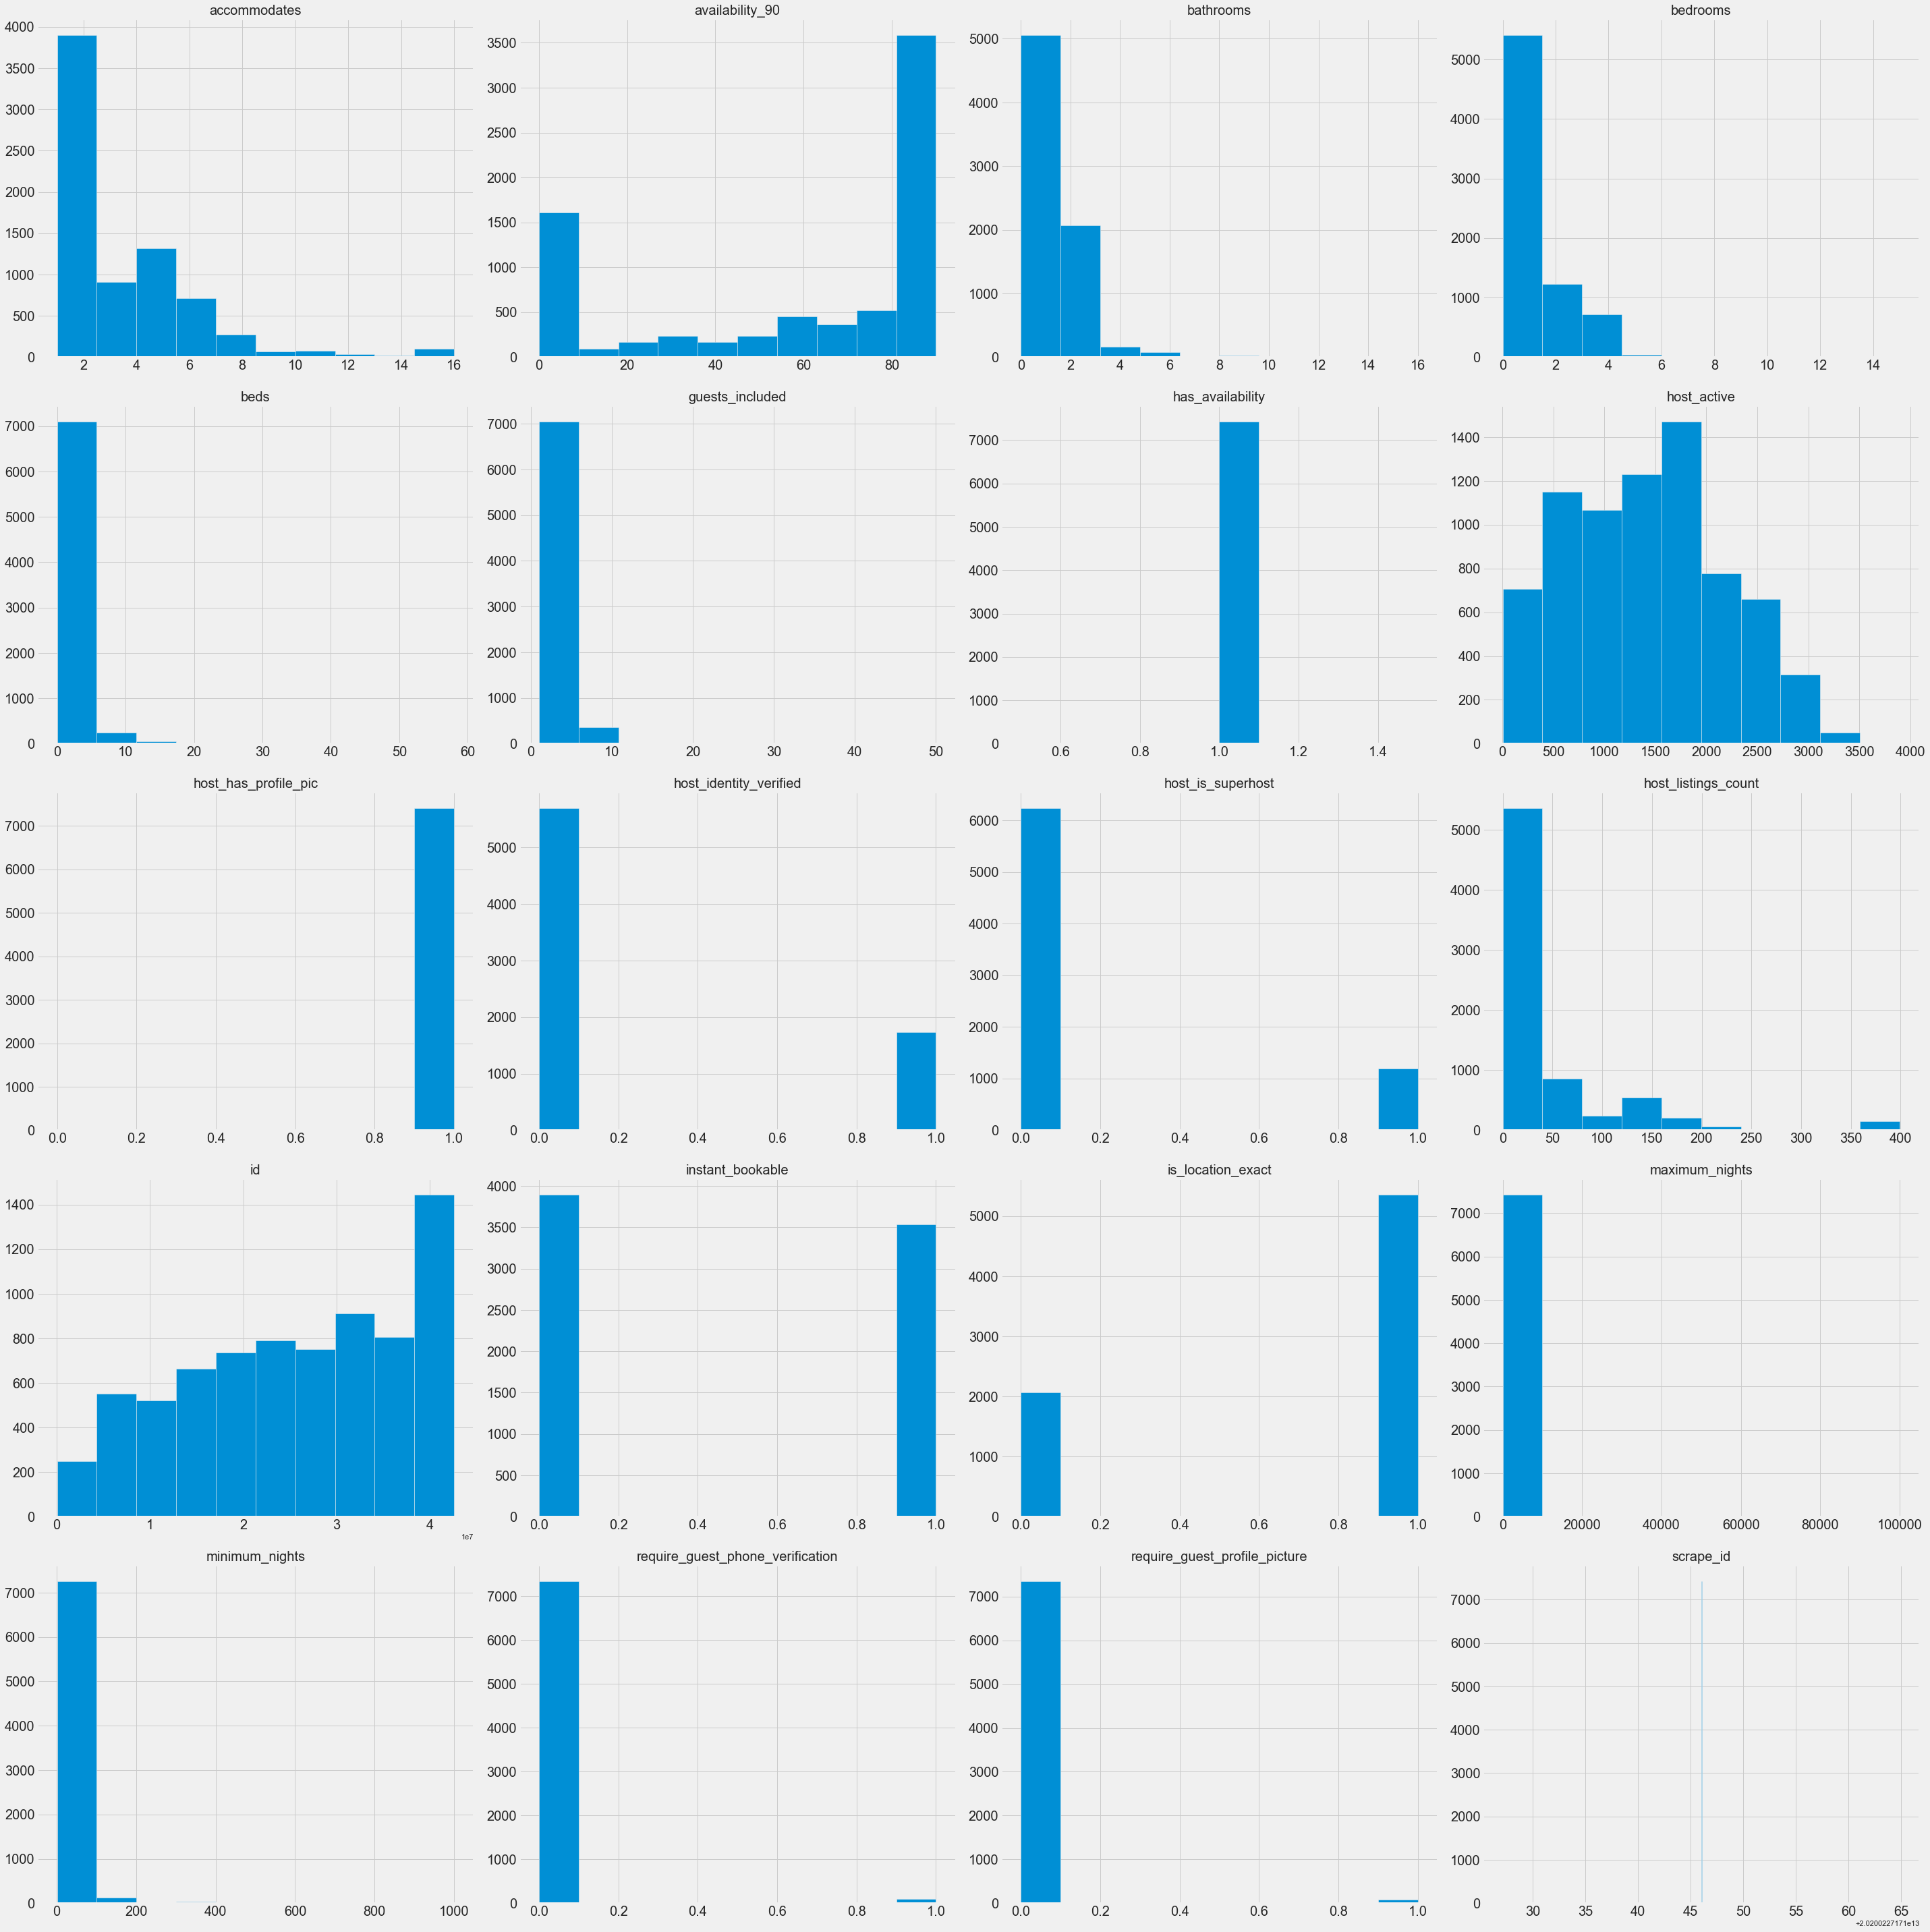

In [34]:
# Replacing columns with f/t with 0/1

airbnb_data.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
airbnb_data.hist(figsize=(40,40), xlabelsize=20, ylabelsize=20);
plt.tight_layout()

From the above, it can be seen that several columns only contain one category and can be dropped:

In [35]:
airbnb_data.drop(['has_availability',
                  'host_has_profile_pic', 
                  'maximum_nights', 
                  'require_guest_phone_verification', 
                  'require_guest_profile_picture',
                  'scrape_id'], axis=1, inplace=True)

#### Numerical

Taking a deeper look with numerical features and cleaning it up.

In [36]:
# convert price to integer, string because of currency
airbnb_data.price = airbnb_data.price.str[1:-3]
airbnb_data.price = airbnb_data.price.str.replace(",", "")
airbnb_data.price = airbnb_data.price.astype('int64')

In [37]:
# convert price to integer, string because of currency
airbnb_data.cleaning_fee = airbnb_data.cleaning_fee.str.replace("$", "")
airbnb_data.cleaning_fee = airbnb_data.cleaning_fee.fillna(0)
airbnb_data.cleaning_fee = airbnb_data.cleaning_fee.astype('float64')

In [38]:
# convert price to integer, string because of currency
airbnb_data.security_deposit = airbnb_data.security_deposit.str.replace("$", "")
airbnb_data.security_deposit = airbnb_data.security_deposit.str.replace(",", "")
airbnb_data.security_deposit = airbnb_data.security_deposit.fillna(0)
airbnb_data.security_deposit = airbnb_data.security_deposit.astype('float64')

In [39]:
# convert price to integer, string because of currency
airbnb_data.extra_people = airbnb_data.extra_people.str.replace("$", "")
airbnb_data.extra_people = airbnb_data.extra_people.fillna(0)
airbnb_data.extra_people = airbnb_data.extra_people.astype('float64')

In [40]:
# overview of statistical summary on numeric data, to check if data makes sense
pd.set_option('float_format', '{:f}'.format)
airbnb_data.describe().T.round(5)

,count,mean,std,min,25%,50%,75%,max
id,7429.000000,25675551.576660,11780700.700390,49091.000000,16421683.000000,27239761.000000,35818917.000000,42578709.000000
host_is_superhost,7429.000000,0.160450,0.367050,0.000000,0.000000,0.000000,0.000000,1.000000
host_listings_count,7429.000000,40.262080,71.369650,0.000000,1.000000,8.000000,45.000000,399.000000
host_identity_verified,7429.000000,0.233010,0.422770,0.000000,0.000000,0.000000,0.000000,1.000000
is_location_exact,7429.000000,0.721360,0.448360,0.000000,0.000000,1.000000,1.000000,1.000000
accommodates,7429.000000,3.366270,2.588870,1.000000,2.000000,2.000000,4.000000,16.000000
bathrooms,7429.000000,1.546980,1.128260,0.000000,1.000000,1.000000,2.000000,16.000000
bedrooms,7429.000000,1.346480,0.975480,0.000000,1.000000,1.000000,2.000000,15.000000
beds,7429.000000,2.016830,2.475590,0.000000,1.000000,1.000000,2.000000,58.000000
price,7429.000000,168.911560,330.337810,0.000000,64.000000,120.000000,196.000000,10000.000000


## EDA
### Distribution of Target Value - Price

In [41]:
# Importing the Singapore neighbourhoods GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('../data/neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Pasir Ris,East Region,"MULTIPOLYGON (((103.95322 1.38201, 103.95350 1..."
1,Seletar,North-East Region,"MULTIPOLYGON (((103.88691 1.42649, 103.88812 1..."
2,Sungei Kadut,North Region,"MULTIPOLYGON (((103.76440 1.44345, 103.76443 1..."
3,Orchard,Central Region,"MULTIPOLYGON (((103.84298 1.30001, 103.84294 1..."
4,Simpang,North Region,"MULTIPOLYGON (((103.86350 1.43433, 103.86361 1..."


In [42]:
# Creating a dataframe of listing counts and median price by area
area_df = pd.DataFrame(airbnb_data.groupby('neighbourhood_cleansed').size())
area_df.rename(columns={0: 'number_of_listings'}, inplace=True)
area_df['median_price'] = airbnb_data.groupby('neighbourhood_cleansed').price.median().values

# Joining the dataframes
sg_map_df = map_df.set_index('neighbourhood').join(area_df)

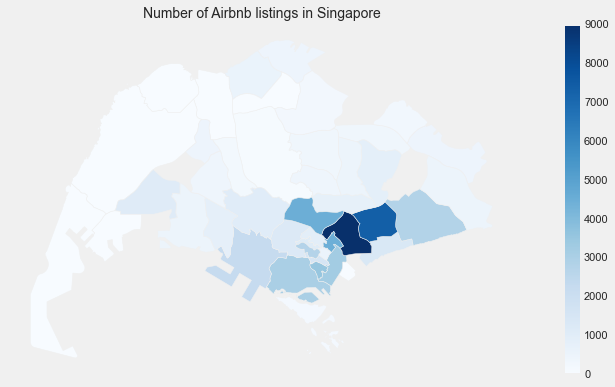

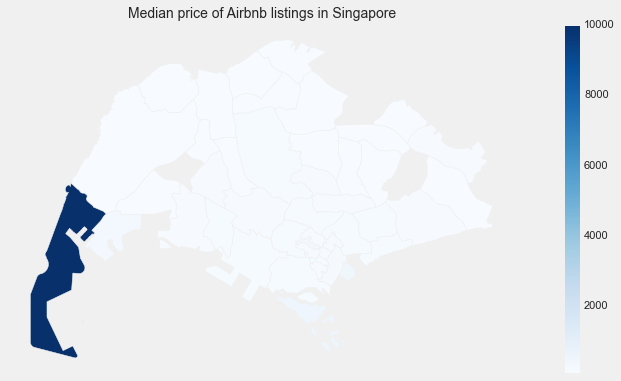

In [43]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
sg_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in Singapore', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
sg_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in Singapore', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(sg_map_df.median_price), vmax=max(sg_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

In [44]:
print(f"Cost of an airbnb apartment for one night in Singapore range from ${min(airbnb_data.price)} to ${max(airbnb_data.price)}.")

Cost of an airbnb apartment for one night in Singapore range from $0 to $10000.


In [45]:
# price should not be zero

airbnb_data.loc[airbnb_data['price']==0,:]

# drop the one that contains zero

,id,host_since,host_is_superhost,host_listings_count,host_verifications,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_90,instant_bookable,cancellation_policy,host_active
2825,21408571,2017-02-03,0,5,"['email', 'phone', 'facebook', 'google', 'revi...",1,Rochor,Central Region,1,Condominium,Entire home/apt,2,1.000000,1.000000,1.000000,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,0.000000,15.000000,1,10.000000,1,69,1,moderate,1119.000000


In [46]:
airbnb_data = airbnb_data.loc[airbnb_data['price']>0,:]

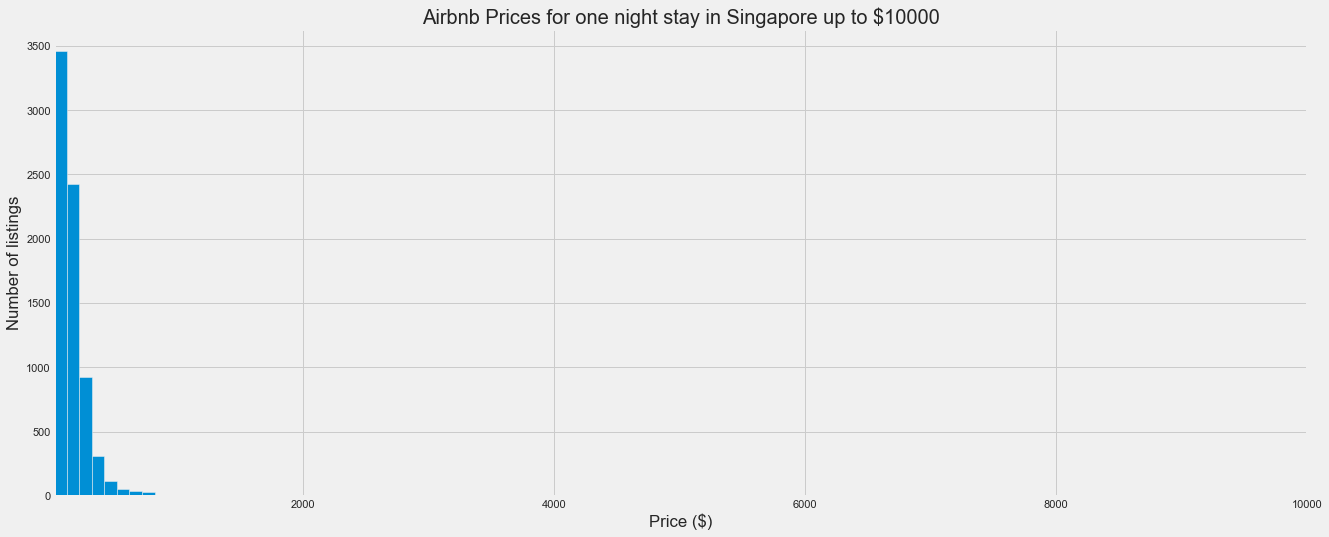

In [47]:
# Distribution of prices from $1 to $10000
plt.figure(figsize=(20,8))
airbnb_data.price.hist(bins=100)
plt.margins(x=0)
plt.title("Airbnb Prices for one night stay in Singapore up to $10000", fontsize=20)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [48]:
# distribution plot below shows that the SalePrice is slightly skewed to the right 
# that is longer tail at right, mean>mode.

print(f"Skew is: {airbnb_data.price.skew()}")

#Try to convert to log scale and check the skewness
print(f"After convert to log scale, skew is: {np.log(airbnb_data.price).skew()}")
# The skewness is much closer to 0, which is closer to normal distribution

Skew is: 18.63032870062051
After convert to log scale, skew is: 0.35905855777584017


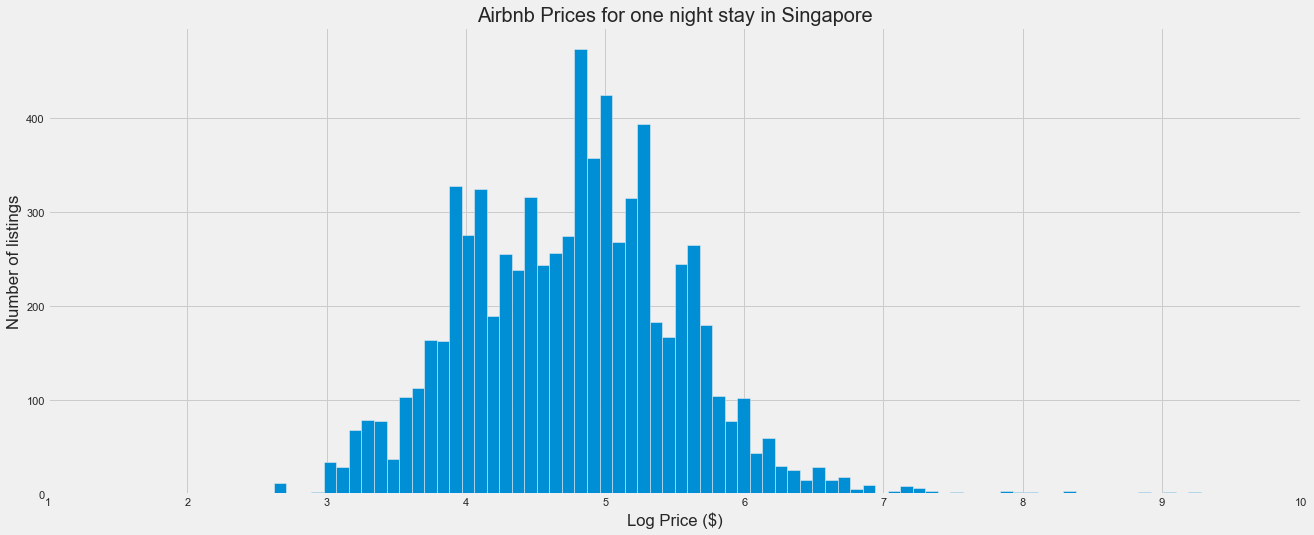

In [49]:
# view the distribution of prices after log
plt.figure(figsize=(20,8))
np.log(airbnb_data.price).hist(bins=100, range=(1,10))
plt.margins(x=0)
# plt.axvline(1, color='orange', linestyle='--')
plt.title("Airbnb Prices for one night stay in Singapore", fontsize=20)
plt.xlabel("Log Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [50]:
# the target SalePrice normally distributed in log scale
# thus will convert it to log scale
airbnb_data.price = np.log(airbnb_data.price)

### Time Series Features

In [51]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(airbnb_data.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(airbnb_data.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 29 June 2009, and the most recent joined on 24 February 2020.


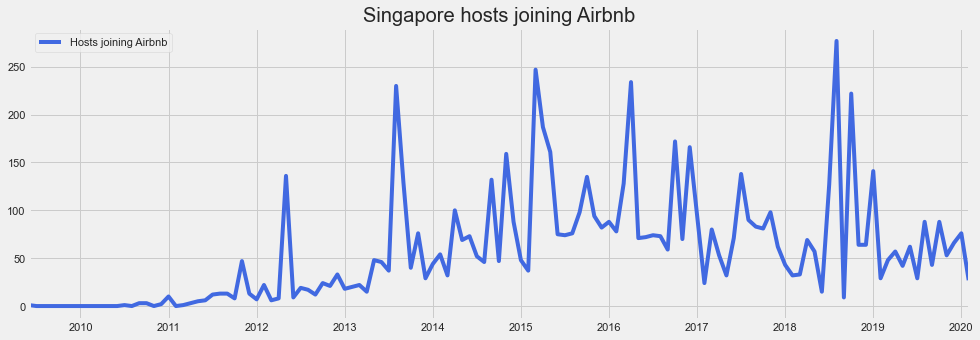

In [52]:
plt.figure(figsize=(15,5))
airbnb_data.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='royalblue')
plt.title('Singapore hosts joining Airbnb')
plt.legend()
plt.xlim('2009-06-29', '2020-02-24') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

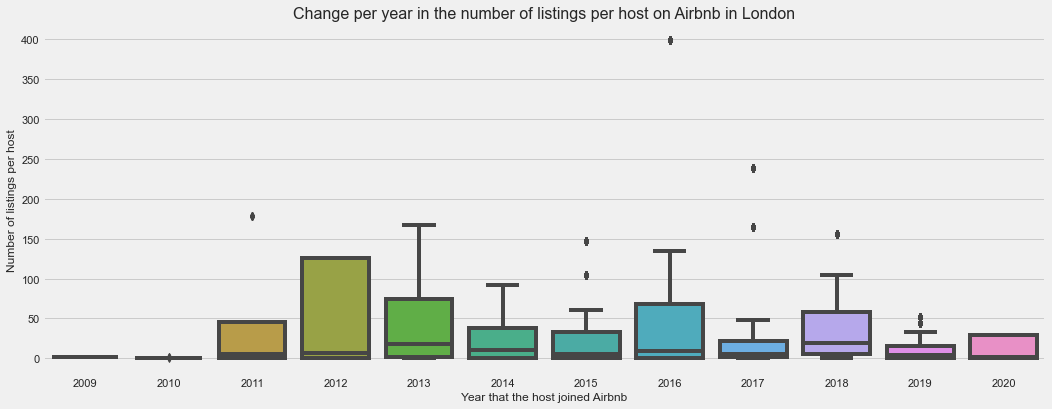

In [53]:
plt.figure(figsize=(16,6))
sns.boxplot(airbnb_data.host_since.dt.year, airbnb_data.host_listings_count)
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in London', fontsize=16)
plt.show()

### Categorical Features

In [54]:
# List out all the categorical features
cat_features = airbnb_data.select_dtypes(include=[object])

# Return a subset of the DataFrame’s columns based on the column dtypes = object
print(f' Total number of categorical features: {cat_features.shape[1]}')
cat_features.dtypes

 Total number of categorical features: 8


host_verifications              object
neighbourhood_cleansed          object
neighbourhood_group_cleansed    object
property_type                   object
room_type                       object
bed_type                        object
amenities                       object
cancellation_policy             object
dtype: object

#### host_verifications

In [55]:
airbnb_data.host_verifications[:5]

0    ['email', 'phone', 'facebook', 'reviews', 'jum...
1    ['email', 'phone', 'facebook', 'reviews', 'off...
2    ['email', 'phone', 'facebook', 'reviews', 'jum...
3    ['email', 'phone', 'reviews', 'manual_offline'...
4    ['email', 'phone', 'reviews', 'manual_offline'...
Name: host_verifications, dtype: object

In [56]:
airbnb_data.host_verifications = airbnb_data.host_verifications.str.replace('[', '')
airbnb_data.host_verifications = airbnb_data.host_verifications.str.replace(']', ',')
airbnb_data.host_verifications = airbnb_data.host_verifications.str.replace('"', '')
airbnb_data.host_verifications = airbnb_data.host_verifications.str.replace("'", '')
airbnb_data.host_verifications = airbnb_data.host_verifications.str.split(',')
airbnb_data.host_verifications = airbnb_data.host_verifications.str.join(',')

In [57]:
host_verification_list = list(airbnb_data.host_verifications)
host_verification_list = " ".join(host_verification_list)
host_verification_list = [x.strip() for x in host_verification_list.split(',')]
host_verification_list_clean = set(host_verification_list)

In [58]:
host_verification_list_clean

{'',
 'email',
 'facebook',
 'google',
 'government_id',
 'identity_manual',
 'jumio',
 'kba',
 'manual_offline',
 'manual_online',
 'offline_government_id',
 'phone',
 'reviews',
 'selfie',
 'sesame',
 'sesame_offline',
 'weibo',
 'work_email',
 'zhima_selfie'}

In [59]:
host_verification_list = pd.Series(host_verification_list)
host_verification_count_top20 = host_verification_list.value_counts().head(20)
host_verification_count_top20

phone                    7390
email                    6709
government_id            5428
reviews                  4411
jumio                    3943
offline_government_id    3605
selfie                   3014
identity_manual          2747
work_email                975
facebook                  564
google                    378
weibo                     198
manual_offline             89
zhima_selfie               46
kba                        19
manual_online              17
                           14
sesame                      4
sesame_offline              4
dtype: int64

In the list above, some of the methods for host verification are more popular. Since there are a couple of overlaps, I will group these into main categories.

The host verification chosen are (slashes indicate separate categories that can be combined):

+ **phone:** phone
+ **email:** email/work_email
+ **id:** government_id/offline_government_id
+ **review:** reviews
+ **photo:** selfie/zhima_selfie
+ **socials:** facebook/google/weibo
+ **others:** jumio/identity_manual/manual_offline/manual_online/sesame/sesame_onffline/kba

In [60]:
airbnb_data.loc[airbnb_data['host_verifications'].str.contains('phone'), 'phone'] = 'true'

In [61]:
# creating new columns whereby specific host verification is present

airbnb_data['phone'] = pd.np.where(airbnb_data.host_verifications.str.contains('phone'),1,0)
airbnb_data['email'] = pd.np.where(airbnb_data.host_verifications.str.contains('email|work_email'),1,0)
airbnb_data['id_verification'] = pd.np.where(airbnb_data.host_verifications.str.contains('government_id|offline_government_id'),1,0)
airbnb_data['review'] = pd.np.where(airbnb_data.host_verifications.str.contains('reviews'),1,0)
airbnb_data['photo'] = pd.np.where(airbnb_data.host_verifications.str.contains('selfie|zhima_selfie'),1,0)
airbnb_data['socials'] = pd.np.where(airbnb_data.host_verifications.str.contains('facebook|google|weibo'),1,0)
airbnb_data['others'] = pd.np.where(airbnb_data.host_verifications.str.contains('jumio|identity_manual|manual_offline|manual_online|sesame|sesame_offline|kba'),1,0)

In [62]:
airbnb_data.id

0          49091
1          50646
2          56334
3          71609
4          71896
          ...   
8042    42573423
8043    42573664
8044    42573768
8045    42578518
8046    42578709
Name: id, Length: 7428, dtype: int64

Since I have categorized this into boolean categories, I will continue with the `host_verification` EDA later on, looking at it as numerical features.

In [63]:
# Define function to plot boxplot for categorical feature

def boxplot_(df, x_col, y_col, xlabel, ylabel, title, p):
    plt.figure(figsize = (p,p))
    
    # boxplot using seaborn
    ax = sns.boxplot(x=x_col, y=y_col, data=df);
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Calculate number of occurance (counts) per category & median to position the counts in boxplot
    medians = airbnb_data.groupby([x_col])[y_col].median().values
    counts = airbnb_data[x_col].value_counts().values     # count the number of occurance for each category
    counts = [str(x) for x in counts.tolist()]
    counts = ["n: " + i for i in counts]
 
    # Add it to the plot
    pos = range(len(counts))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.03, counts[tick],
            horizontalalignment='center', size='x-small', color='k', weight='semibold')

#### neighbourhood_cleansed

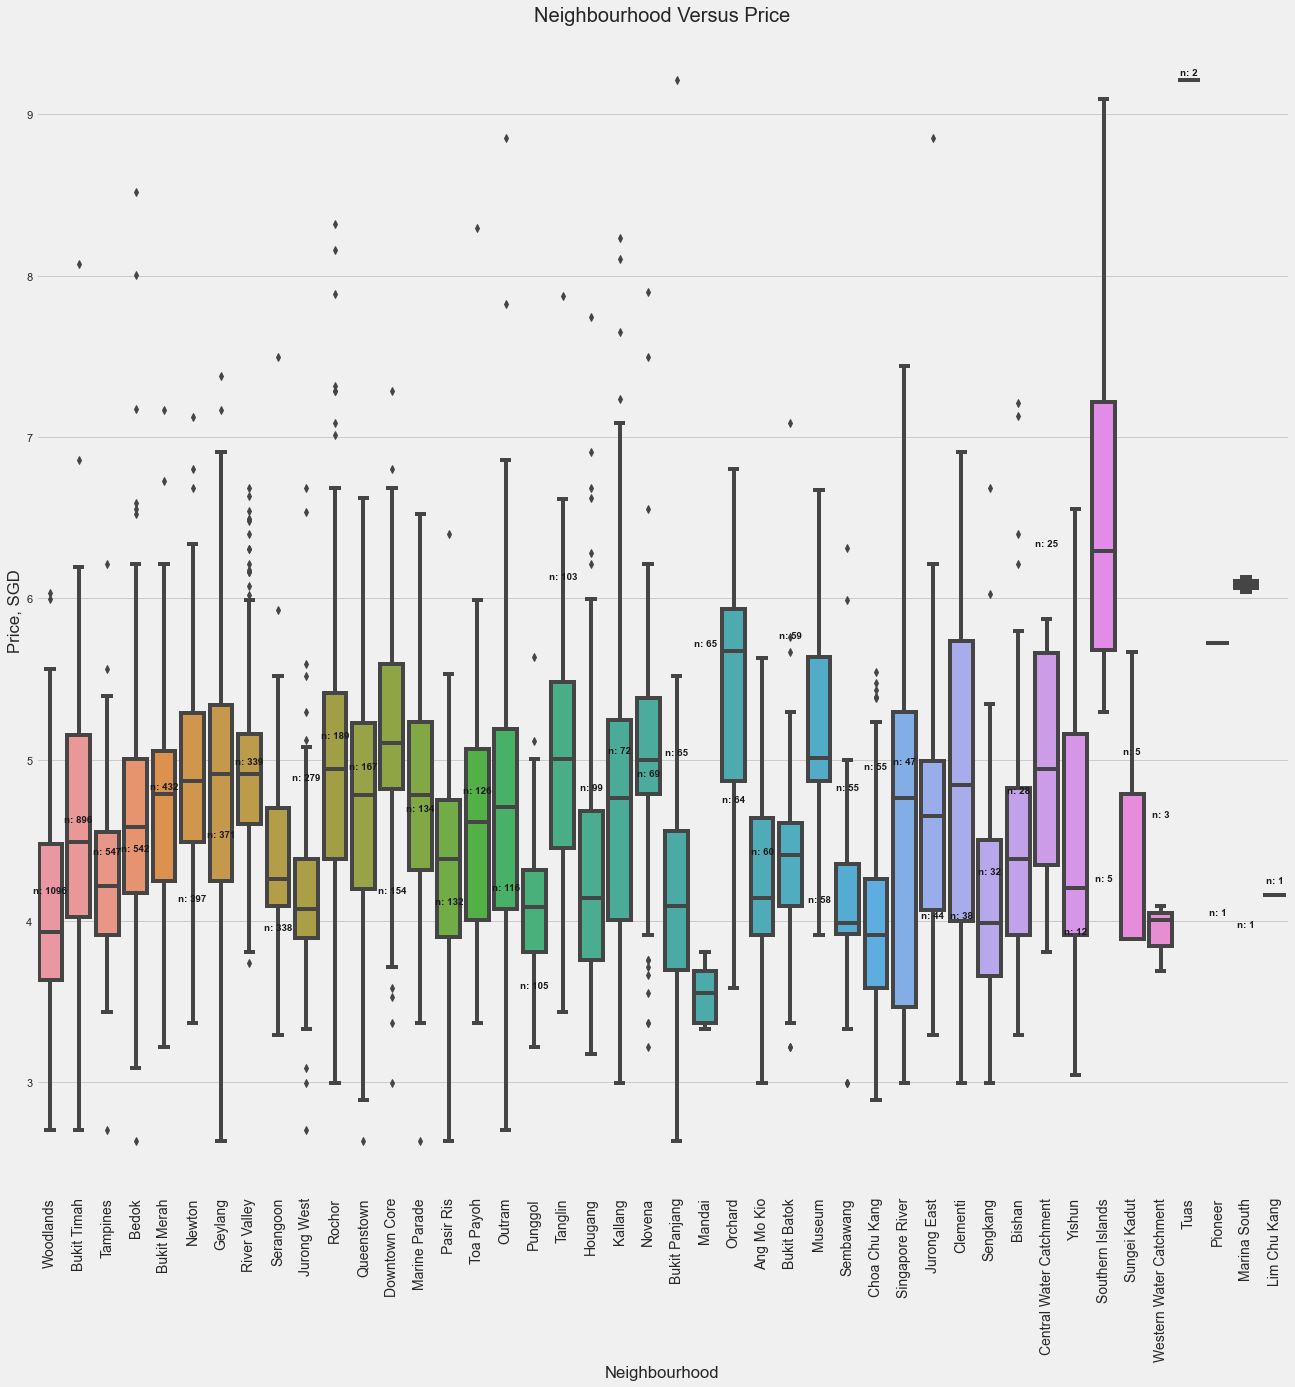

In [64]:
boxplot_(airbnb_data,'neighbourhood_cleansed', 'price', 'Neighbourhood', 'Price, SGD',
        'Neighbourhood Versus Price', 20)
plt.xticks(rotation=90, fontsize = 14);

In [65]:
airbnb_data.loc[airbnb_data['neighbourhood_cleansed']=='Southern Islands'].price.sort_values(ascending = False)

3104   9.093807
1887   9.093694
4840   8.994917
1400   8.323608
1628   7.987185
7020   7.365180
4306   7.215975
1271   7.166266
2838   7.166266
4862   6.672033
1351   6.639876
3160   6.552508
3159   6.291569
7203   6.272877
1093   6.173786
6930   5.996452
6910   5.855072
3154   5.811141
6963   5.680173
7044   5.680173
7023   5.627621
7740   5.521461
7735   5.521461
7722   5.521461
4827   5.298317
Name: price, dtype: float64

In [66]:
airbnb_data.iloc[3010]

id                                                                       22617828
host_since                                                    2016-07-18 00:00:00
host_is_superhost                                                               0
host_listings_count                                                            10
host_verifications                            email, phone, facebook, work_email,
host_identity_verified                                                          0
neighbourhood_cleansed                                           Southern Islands
neighbourhood_group_cleansed                                       Central Region
is_location_exact                                                               1
property_type                                                               House
room_type                                                         Entire home/apt
accommodates                                                                    6
bathrooms       

#### neighbourhood_group_cleansed

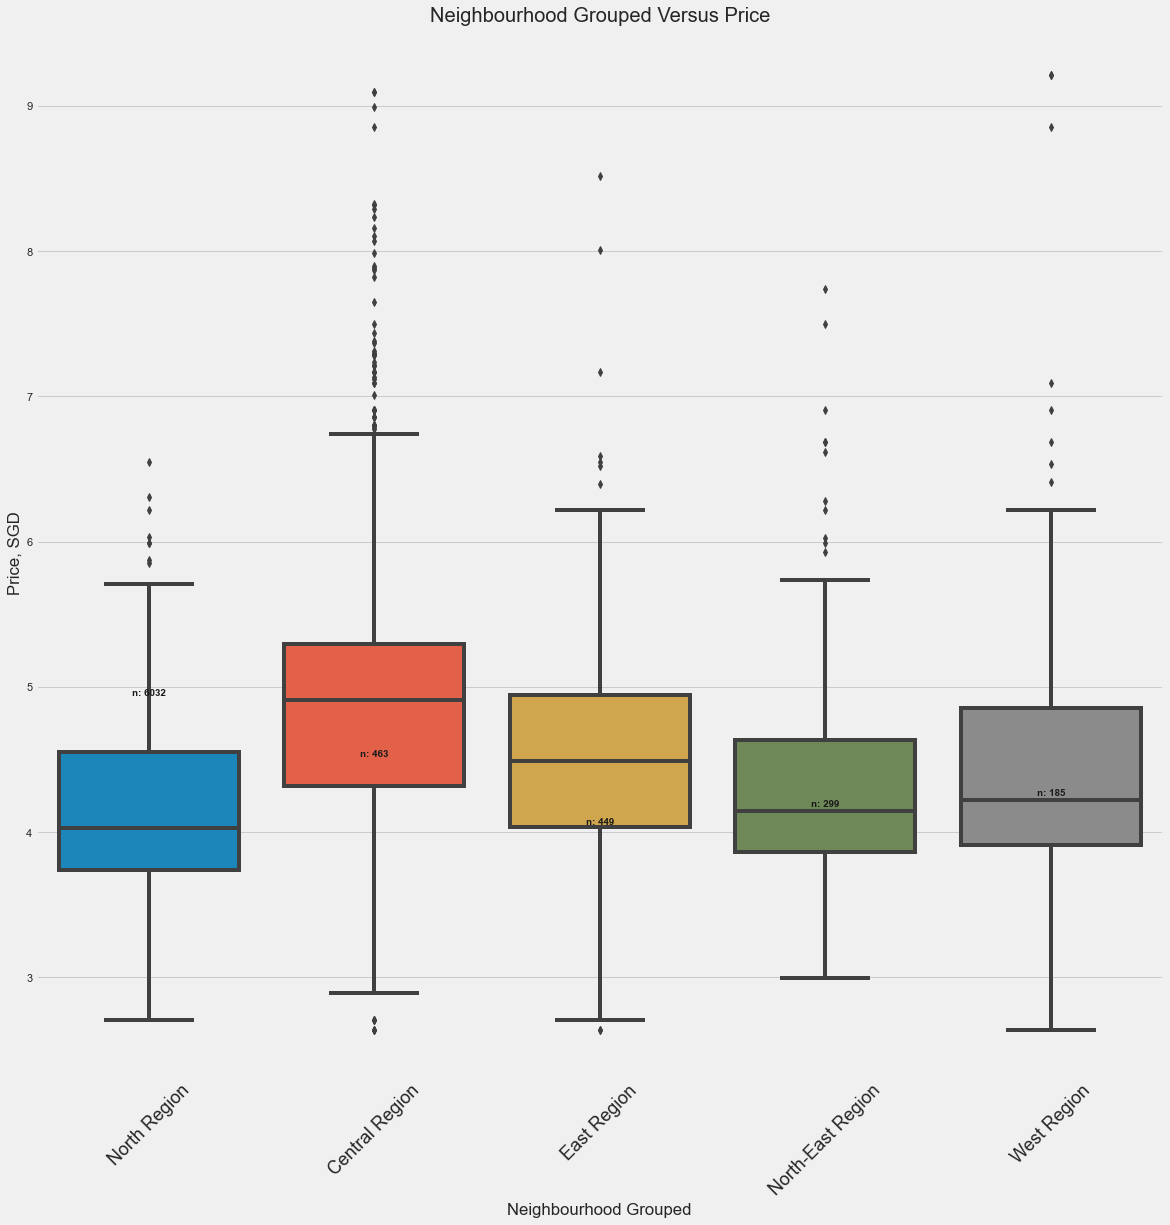

In [67]:
boxplot_(airbnb_data,'neighbourhood_group_cleansed', 'price', 'Neighbourhood Grouped', 'Price, SGD',
        'Neighbourhood Grouped Versus Price', 18)

plt.xticks(rotation=45, fontsize = 18);

#### property_type

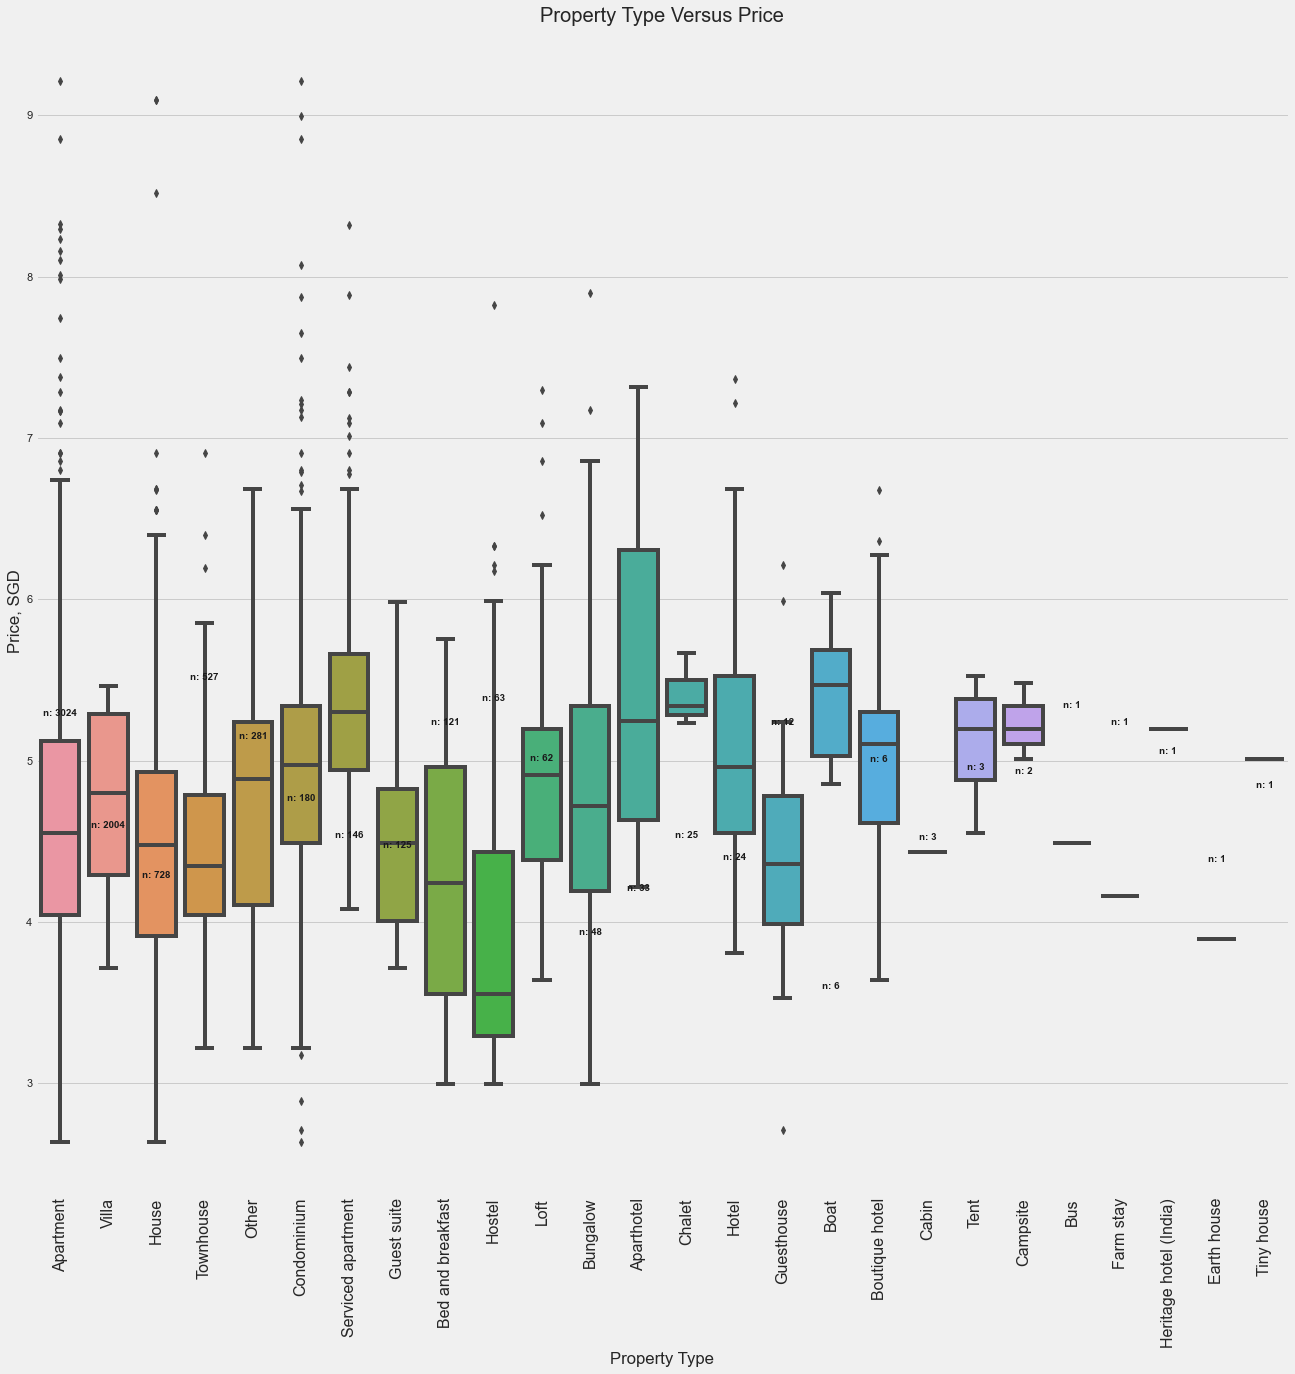

In [68]:
boxplot_(airbnb_data,'property_type', 'price', 'Property Type', 'Price, SGD',
        'Property Type Versus Price', 20)


plt.xticks(rotation=90, fontsize = 16);

In [69]:
airbnb_data.property_type.value_counts()

Apartment                 3024
Condominium               2004
Serviced apartment         728
House                      527
Hostel                     281
Boutique hotel             180
Hotel                      146
Loft                       125
Townhouse                  121
Bungalow                    63
Bed and breakfast           62
Other                       48
Aparthotel                  33
Guesthouse                  25
Guest suite                 24
Villa                       12
Tent                         6
Boat                         6
Campsite                     3
Chalet                       3
Tiny house                   2
Heritage hotel (India)       1
Cabin                        1
Earth house                  1
Bus                          1
Farm stay                    1
Name: property_type, dtype: int64

In the list above, some of the `property_types` only consist of a couple of listings. Thus, I will group these into main categories, such as apartment, hotel, others.

The property types chosen are categorised as followed:

+ **apartment:** 
    - apartment
    - serviced apartment
    - condominium
    - loft
    - house
    - tiny house
    - townhouse
    - guesthouse
    - bungalow
+ **hotel:** 
    - boutique hotel
    - heritage hotel(india)
    - hotel
    - aparthotel
+ **others:** 
    - hostel
    - bed and breakfast
    - other
    - guest suite
    - villa
    - boat
    - tent
    - campsite
    - chalet
    - farm stay
    - bus
    - cabin
    - earth house

In [70]:
airbnb_data['grouped_property_type'] = pd.np.where(airbnb_data.property_type.str.contains('Apartment|Serviced apartment|Condominium|House|Tiny house|Townhouse|Guesthouse|Bungalow'),'apartment',
                                       pd.np.where(airbnb_data.property_type.str.contains('Boutique hotel|Heritage hotel (India)|Hotel|Aparthotel'), 'hotel', 'others'))

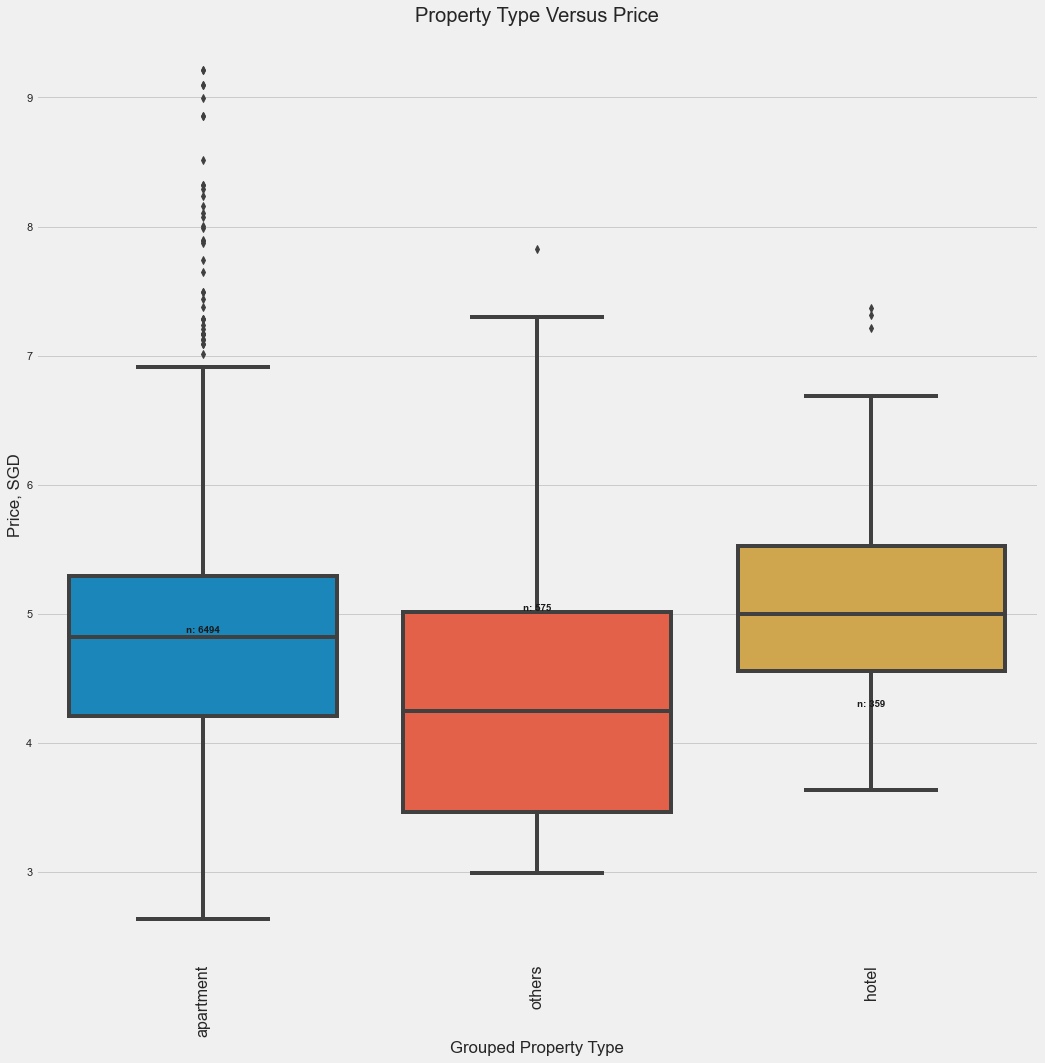

In [71]:
boxplot_(airbnb_data,'grouped_property_type', 'price', 'Grouped Property Type', 'Price, SGD',
        'Property Type Versus Price', 16)


plt.xticks(rotation=90, fontsize = 16);

#### room_type

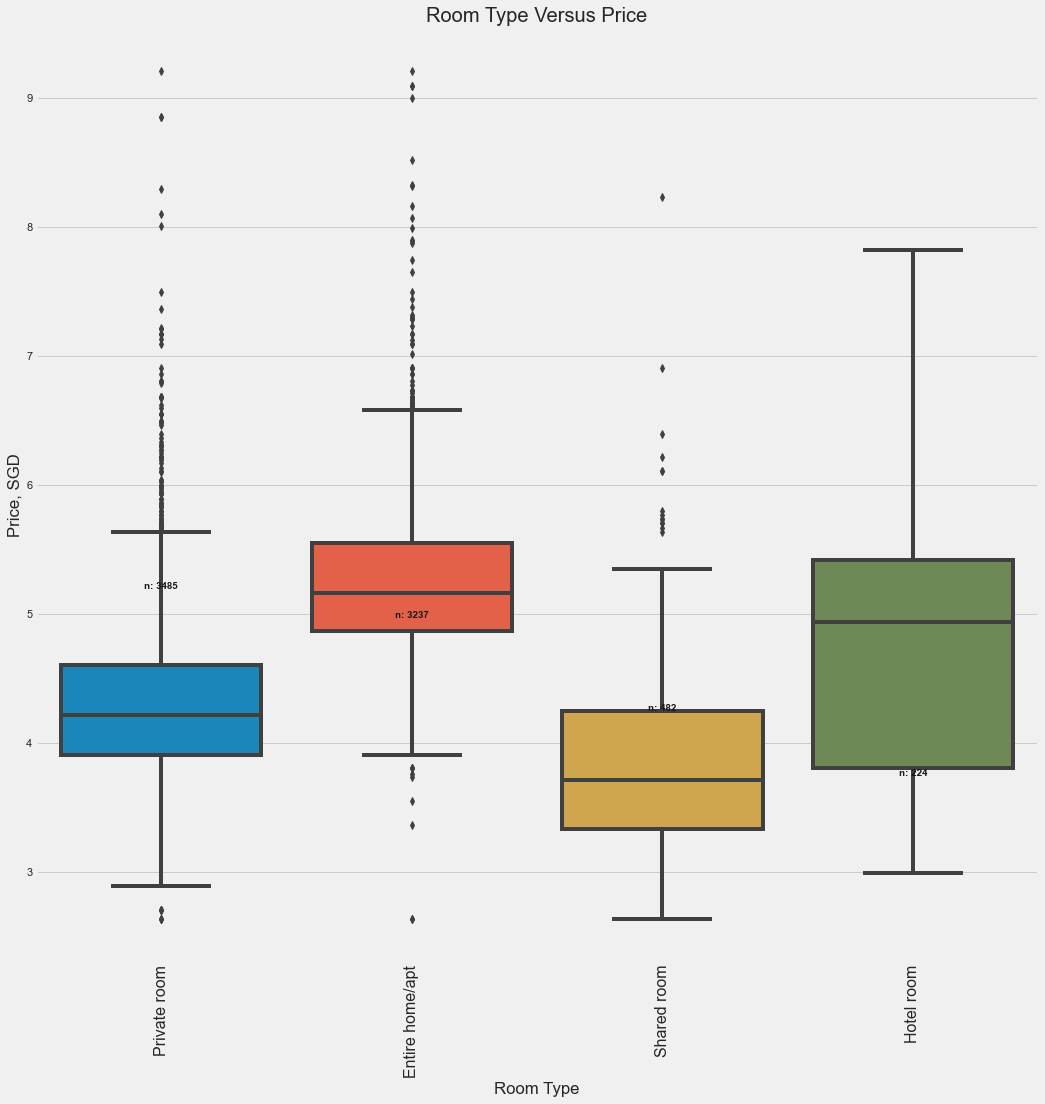

In [72]:
boxplot_(airbnb_data,'room_type', 'price', 'Room Type', 'Price, SGD',
        'Room Type Versus Price', 16)


plt.xticks(rotation=90, fontsize = 16);

#### bed_type

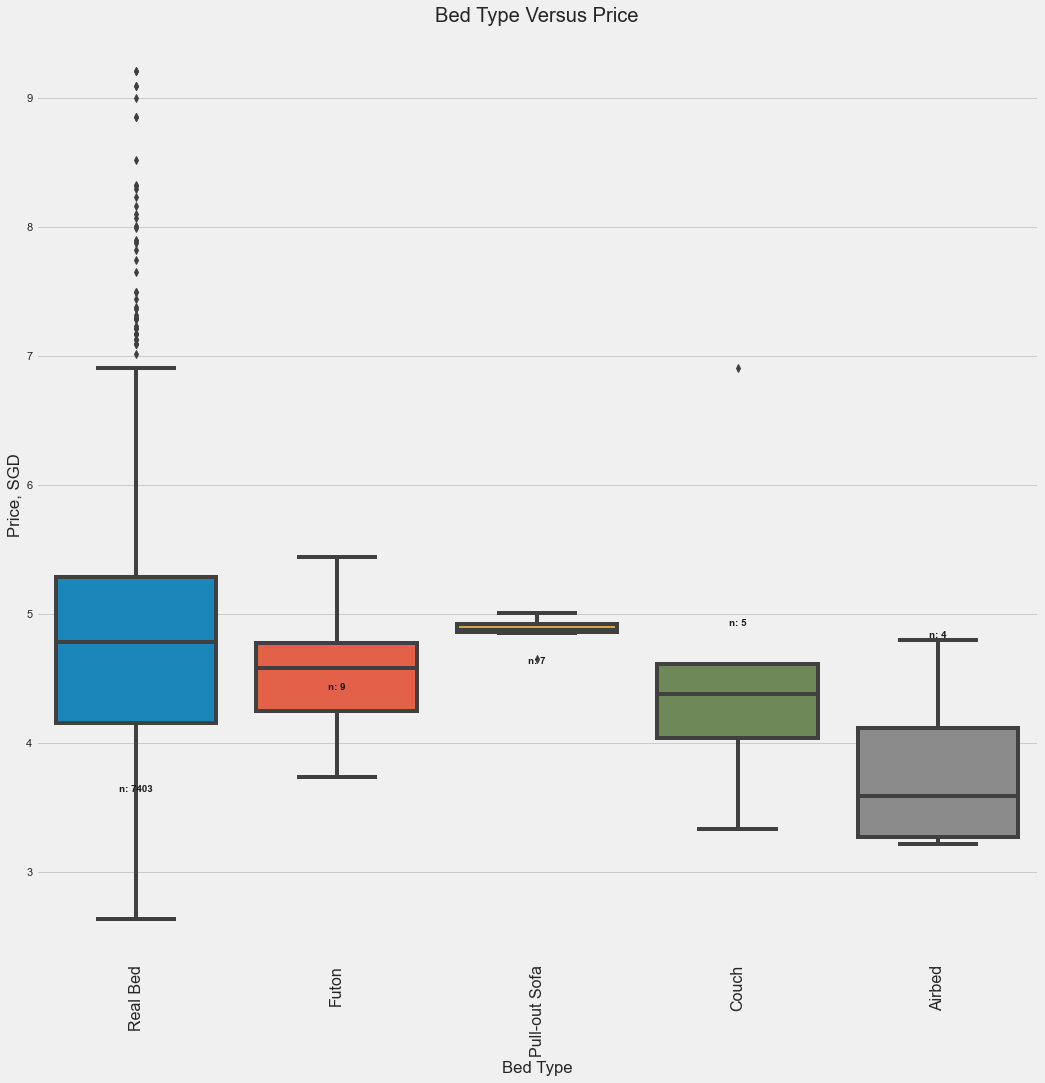

In [73]:
boxplot_(airbnb_data,'bed_type', 'price', 'Bed Type', 'Price, SGD',
        'Bed Type Versus Price', 16)


plt.xticks(rotation=90, fontsize = 16);

#### amenities

In [74]:
airbnb_data.amenities[:5]

0    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
2    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
3    {TV,Wifi,"Air conditioning",Kitchen,"Pets live...
4    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
Name: amenities, dtype: object

In [75]:
airbnb_data.amenities = airbnb_data.amenities.str.replace('{','')
airbnb_data.amenities = airbnb_data.amenities.str.replace('}', ',')
airbnb_data.amenities = airbnb_data.amenities.str.replace('"', '')
airbnb_data.amenities = airbnb_data.amenities.str.split(',')

In [76]:
airbnb_data.amenities

0       [TV, Cable TV, Internet, Wifi, Air conditionin...
1       [TV, Cable TV, Internet, Wifi, Air conditionin...
2       [TV, Cable TV, Wifi, Air conditioning, Kitchen...
3       [TV, Wifi, Air conditioning, Kitchen, Pets liv...
4       [TV, Internet, Wifi, Air conditioning, Kitchen...
                              ...                        
8042    [TV, Cable TV, Wifi, Air conditioning, Pool, K...
8043    [TV, Cable TV, Wifi, Air conditioning, Pool, K...
8044    [TV, Cable TV, Wifi, Air conditioning, Pool, K...
8045    [TV, Wifi, Air conditioning, Pool, Kitchen, Gy...
8046    [TV, Wifi, Air conditioning, Pool, Kitchen, Gy...
Name: amenities, Length: 7428, dtype: object

In [77]:
airbnb_data.amenities = airbnb_data.amenities.str.join(',')

In [78]:
airbnb_data[['amenities']]

,amenities
0,"TV,Cable TV,Internet,Wifi,Air conditioning,Pet..."
1,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo..."
2,"TV,Cable TV,Wifi,Air conditioning,Kitchen,Pets..."
3,"TV,Wifi,Air conditioning,Kitchen,Pets live on ..."
4,"TV,Internet,Wifi,Air conditioning,Kitchen,Pets..."
...,...
8042,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen..."
8043,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen..."
8044,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen..."
8045,"TV,Wifi,Air conditioning,Pool,Kitchen,Gym,Elev..."


In [79]:
# looking at amenities

airbnb_data.amenities

0       TV,Cable TV,Internet,Wifi,Air conditioning,Pet...
1       TV,Cable TV,Internet,Wifi,Air conditioning,Poo...
2       TV,Cable TV,Wifi,Air conditioning,Kitchen,Pets...
3       TV,Wifi,Air conditioning,Kitchen,Pets live on ...
4       TV,Internet,Wifi,Air conditioning,Kitchen,Pets...
                              ...                        
8042    TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...
8043    TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...
8044    TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...
8045    TV,Wifi,Air conditioning,Pool,Kitchen,Gym,Elev...
8046    TV,Wifi,Air conditioning,Pool,Kitchen,Gym,Elev...
Name: amenities, Length: 7428, dtype: object

In [80]:
# getting a list of all amenities present

amenities_all = list(airbnb_data.amenities)
amenities_all = " ".join(amenities_all)

In [81]:
# list comprehension to get amenities into one list

amenities_list = [x.strip() for x in amenities_all.split(',')]

In [82]:
# taking a look at the top 20 amenities

amenities_list = pd.Series(amenities_list)
amenities_count_top20 = amenities_list.value_counts().head(20)

In [83]:
# there are 129 types of different amenities

print(len(set(amenities_list)))
(set(amenities_list))

129


{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Barbecue utensils',
 'Bathtub',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bread maker',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower',
 'Fixed grab bars for toilet',
 'Flat path to guest entrance',
 

In [84]:
amenities_count_top20

Air conditioning             7191
Wifi                         7175
Washer                       6550
Essentials                   6547
Kitchen                      6094
Hangers                      6010
Iron                         5617
TV                           5421
Hair dryer                   5410
Shampoo                      5303
Laptop friendly workspace    5237
Elevator                     4809
Dryer                        4677
Hot water                    4401
Lock on bedroom door         4115
Pool                         3734
Refrigerator                 3212
Long term stays allowed      3100
Gym                          3044
Microwave                    2890
dtype: int64

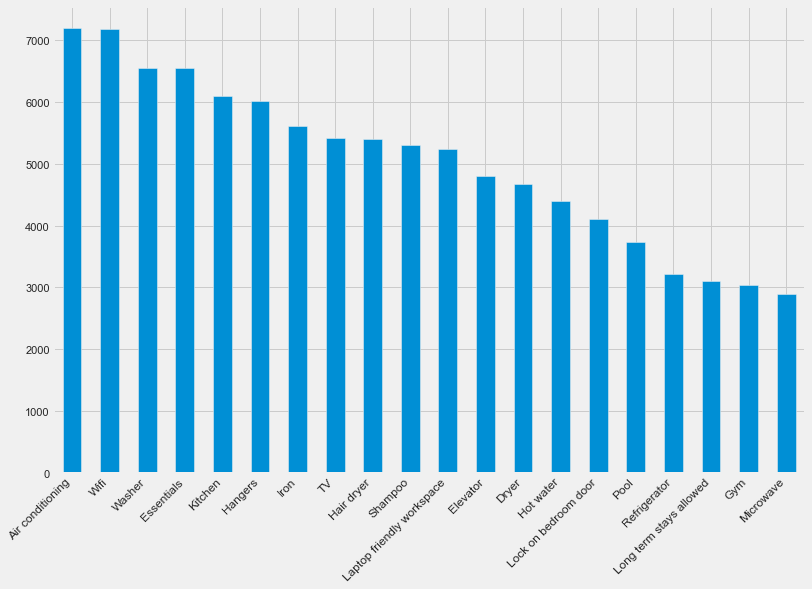

In [85]:
plt.figure(figsize=(12,8))
amenities_count_top20.plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

In the list above, there are 129 different types of listed amenities. I will extract the top 20, for further observation as to how having/not having a particular amenity would affect the price.

These are the top 20 amenities:

+ Air conditioning         
+ Wifi                     
+ Washer                   
+ Essentials               
+ Kitchen                  
+ Hangers                  
+ Iron                     
+ TV                       
+ Hair dryer               
+ Shampoo                  
+ Laptop friendly workspace
+ Elevator                 
+ Dryer                    
+ Hot water                
+ Lock on bedroom door     
+ Pool                     
+ Refrigerator             
+ Long term stays allowed  
+ Gym                      
+ Microwave                

In [86]:
airbnb_data['air_con'] = pd.np.where(airbnb_data.amenities.str.contains('Air conditioning'),1,0)
airbnb_data['wifi'] = pd.np.where(airbnb_data.amenities.str.contains('Wifi'),1,0)
airbnb_data['washer'] = pd.np.where(airbnb_data.amenities.str.contains('Washer'),1,0)
airbnb_data['essentials'] = pd.np.where(airbnb_data.amenities.str.contains('Essentials'),1,0)
airbnb_data['kitchen'] = pd.np.where(airbnb_data.amenities.str.contains('Kitchen'),1,0)
airbnb_data['hangers'] = pd.np.where(airbnb_data.amenities.str.contains('Hangers'),1,0)
airbnb_data['iron'] = pd.np.where(airbnb_data.amenities.str.contains('Iron'),1,0)
airbnb_data['tv'] = pd.np.where(airbnb_data.amenities.str.contains('TV'),1,0)
airbnb_data['hair_dryer'] = pd.np.where(airbnb_data.amenities.str.contains('Hair dryer'),1,0)
airbnb_data['shampoo'] = pd.np.where(airbnb_data.amenities.str.contains('Shampoo'),1,0)
airbnb_data['laptop_workspace'] = pd.np.where(airbnb_data.amenities.str.contains('Laptop friendly workspace'),1,0)
airbnb_data['elevator'] = pd.np.where(airbnb_data.amenities.str.contains('Elevator'),1,0)
airbnb_data['dryer'] = pd.np.where(airbnb_data.amenities.str.contains('Dryer'),1,0)
airbnb_data['hot_water'] = pd.np.where(airbnb_data.amenities.str.contains('Hot water'),1,0)
airbnb_data['bedroom_lock'] = pd.np.where(airbnb_data.amenities.str.contains('Lock on bedroom door'),1,0)
airbnb_data['pool'] = pd.np.where(airbnb_data.amenities.str.contains('Pool'),1,0)
airbnb_data['refrigerator'] = pd.np.where(airbnb_data.amenities.str.contains('Refrigerator'),1,0)
airbnb_data['long_term_stays'] = pd.np.where(airbnb_data.amenities.str.contains('Long term stays allowed'),1,0)
airbnb_data['gym'] = pd.np.where(airbnb_data.amenities.str.contains('Gym'),1,0)
airbnb_data['microwave'] = pd.np.where(airbnb_data.amenities.str.contains('Microwave'),1,0)

Since I have categorized this into boolean categories, I will continue with the `amenities` EDA later on, looking at it as numerical features.

#### cancellation_policy

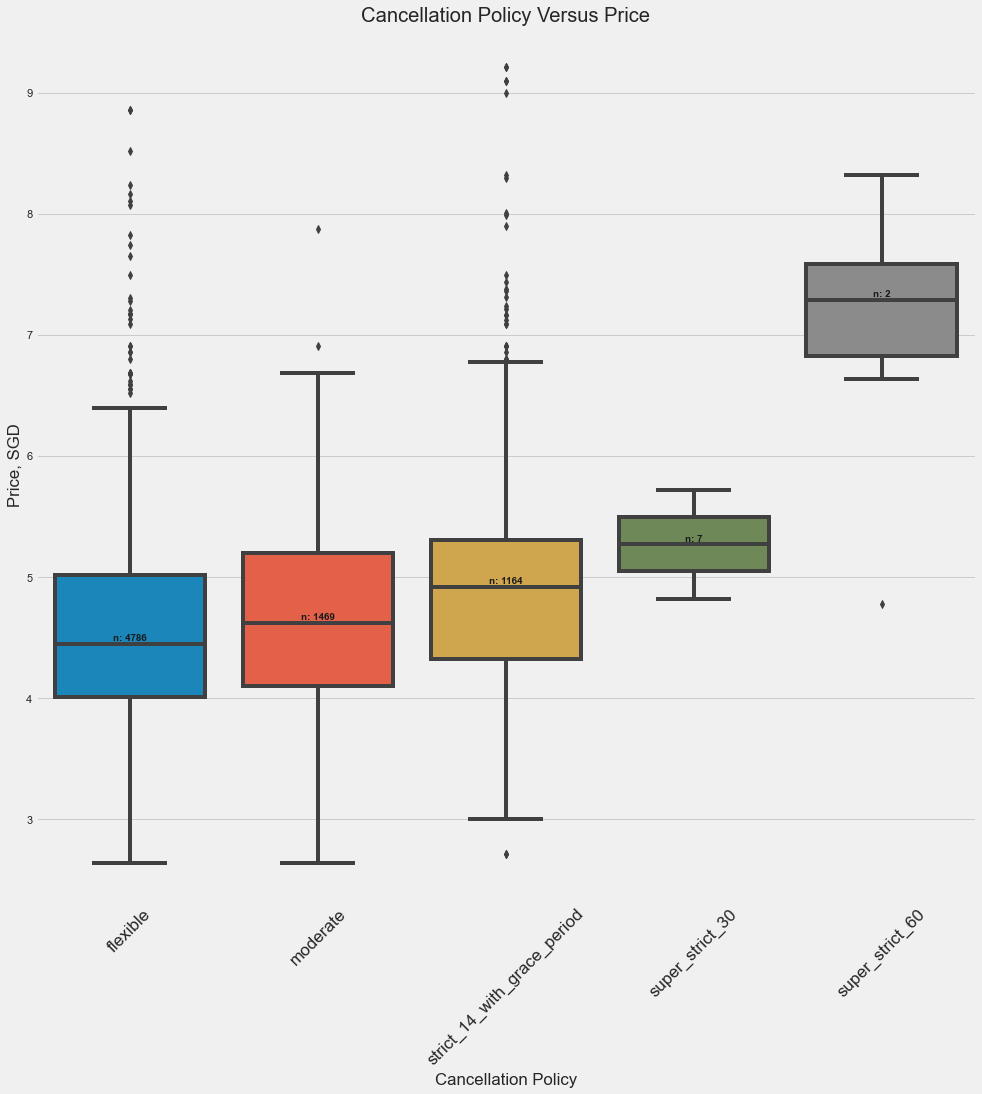

In [87]:
boxplot_(airbnb_data,'cancellation_policy', 'price', 'Cancellation Policy', 'Price, SGD',
        'Cancellation Policy Versus Price', 15)


plt.xticks(rotation=45, fontsize = 17);

### Numerical Features

In [88]:
# List out all the numerical features

num_features = airbnb_data.select_dtypes(include=[np.number])

# Return a subset of the DataFrame’s columns based on the column dtypes = numeric number

print(f' Total number of numeric features: {num_features.shape[1]}')
num_features.dtypes

 Total number of numeric features: 45


id                          int64
host_is_superhost           int64
host_listings_count         int64
host_identity_verified      int64
is_location_exact           int64
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
price                     float64
security_deposit          float64
cleaning_fee              float64
guests_included             int64
extra_people              float64
minimum_nights              int64
availability_90             int64
instant_bookable            int64
host_active               float64
phone                       int64
email                       int64
id_verification             int64
review                      int64
photo                       int64
socials                     int64
others                      int64
air_con                     int64
wifi                        int64
washer                      int64
essentials                  int64
kitchen       

#### Numerical features Vs Price
There is a total of 45 numerical features. Taking a quick view of how they correlate with price.

In [89]:
# Numeric features correlation 

num_features_corr = airbnb_data.corr()[['price']]

#List of correction of sale price versus the 22 numerical features

num_features_corr.sort_values(by = ['price'], ascending = False).T

,price,accommodates,bedrooms,guests_included,tv,cleaning_fee,hair_dryer,gym,pool,shampoo,extra_people,elevator,iron,kitchen,host_listings_count,beds,dryer,id,photo,security_deposit,id_verification,hangers,availability_90,microwave,essentials,bathrooms,host_is_superhost,air_con,refrigerator,long_term_stays,laptop_workspace,others,is_location_exact,hot_water,washer,phone,socials,wifi,email,instant_bookable,review,minimum_nights,host_identity_verified,host_active,bedroom_lock
price,1.000000,0.521500,0.462005,0.427939,0.379207,0.302547,0.284390,0.259744,0.234850,0.221378,0.217976,0.211700,0.207378,0.204881,0.184323,0.181784,0.164730,0.160653,0.152889,0.147890,0.134314,0.114969,0.102286,0.099055,0.098426,0.096597,0.093562,0.091909,0.090141,0.088356,0.086995,0.086698,0.034404,0.029164,0.024338,0.020908,0.011469,-0.009022,-0.021629,-0.051606,-0.074873,-0.099061,-0.108694,-0.139397,-0.163696


In [90]:
# To list out features with relatively strong postive and strong negative correlation with price:
strong_pos = num_features_corr['price'] > 0.3   
strong_neg = num_features_corr['price'] < -0.1 

strong_nfeatures = num_features_corr[strong_pos | strong_neg].index   # list of features with strong correlation to price
print(f'Total of {num_features_corr[strong_pos | strong_neg].shape[0] -1} stronger correlation features')

num_features_corr[strong_pos | strong_neg].sort_values(by = 'price', ascending = False).T

Total of 8 stronger correlation features


,price,accommodates,bedrooms,guests_included,tv,cleaning_fee,host_identity_verified,host_active,bedroom_lock
price,1.000000,0.521500,0.462005,0.427939,0.379207,0.302547,-0.108694,-0.139397,-0.163696


In [91]:
# Unstack the correlation matrix (extract those with stronger positive correlation among the numeric features)

x = airbnb_data.corr().unstack()
x[ ((x>0.6) & (x<1.0)) ]

accommodates     bedrooms          0.670952
                 beds              0.641532
bedrooms         accommodates      0.670952
beds             accommodates      0.641532
host_active      review            0.619121
id_verification  others            0.820594
review           host_active       0.619121
others           id_verification   0.820594
pool             gym               0.745578
refrigerator     microwave         0.864673
gym              pool              0.745578
microwave        refrigerator      0.864673
dtype: float64

In [92]:
y = airbnb_data.corr().unstack()
y[ ((y<(-0.6)) & (y>(-1.0))) ]

Series([], dtype: float64)

From the above, there is no negative correlation that reduces prices that is significant.

**Numeric features with correlation to Price**

By going through the sorted list of stronger correlation features, we observed that there seems to be some correlation between the numeric features and price, with the highest correlation being at 0.52.

1. `accomodates` has the highest correlation with `price`.

2. `bedrooms` comes in as a close 2nd for correlation with `price`. However, it is also correlated to accomodates, which indicates that multicollinearity exists.

3. All the correlations do make some sense, where we would generally expect a higher price for the increase in number of `accomodates`, `bedrooms`, `guests_included` and presence of `tv`.

In [93]:
# ploting the histograms to show the distribution of numeric features

def hist_plot(feature, binsize, xlabel, title):
    plt.figure(figsize = (12,6));
    airbnb_data[feature].plot(kind = 'hist', bins = binsize, rwidth = 0.9, color = 'royalblue', alpha = 0.9);
    
    plt.xlabel(xlabel, fontsize = 14)
    plt.ylabel('Counts', fontsize = 14)
    plt.title(title, fontsize = 20)
    plt.grid(axis ='y', alpha = 0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

In [94]:
# ploting the counts of true and false categories next to the median price for the category

def boolean_features(col, figsize=(8,3)):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=15, y=1)
    plt.subplots_adjust(top=0.80) # So that the subtitle does not overlap with the ax plot titles
    
    airbnb_data.groupby(col).size().plot(kind='bar', ax=ax1, color=['darkslategray', 'mediumaquamarine'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count', fontsize=12)
    ax1.set_xlabel('')
    
    airbnb_data.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['darkslategray', 'mediumaquamarine'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Log Median price (SGD)', fontsize=12)
    ax2.set_xlabel('')
    
    plt.show()

#### host_is_superhost

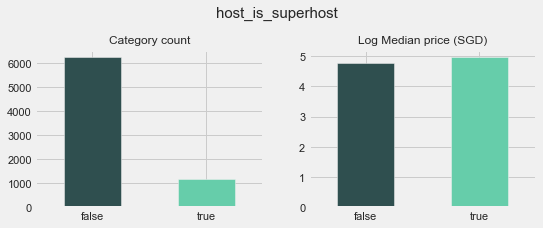

0   0.839526
1   0.160474
Name: host_is_superhost, dtype: float64


In [95]:
# taking a look at the relationship between host_is_superhost and median 
# price in that category

boolean_features('host_is_superhost')
print(airbnb_data.host_is_superhost.value_counts(normalize=True))

#### host_listings_count

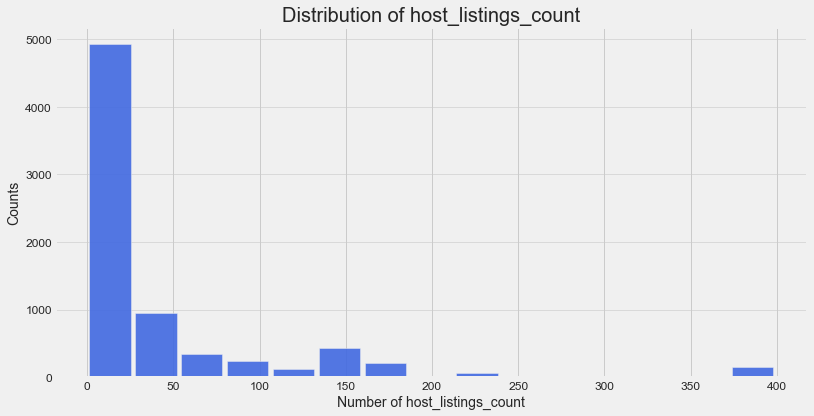

In [96]:
# distribution of the 'host_listings_count'

hist_plot('host_listings_count', 15, 'Number of host_listings_count', 'Distribution of host_listings_count')

# the number of host_listings_count falls below 50

#### host_identity_verified

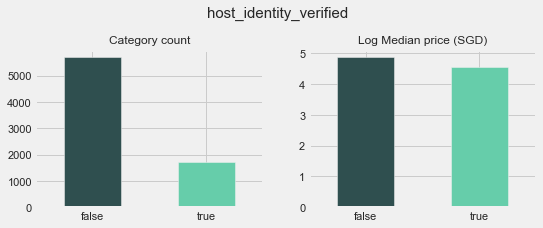

0   0.767097
1   0.232903
Name: host_identity_verified, dtype: float64


In [97]:
# taking a look at the relationship between host_identity_verified and median 
# price in that category

boolean_features('host_identity_verified')
print(airbnb_data.host_identity_verified.value_counts(normalize=True))

#### is_location_exact  

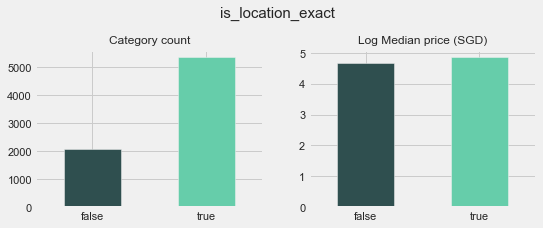

1   0.721325
0   0.278675
Name: is_location_exact, dtype: float64


In [98]:
# taking a look at the relationship between is_location_exact and median 
# price in that category

boolean_features('is_location_exact')
print(airbnb_data.is_location_exact.value_counts(normalize=True))

#### accomodates

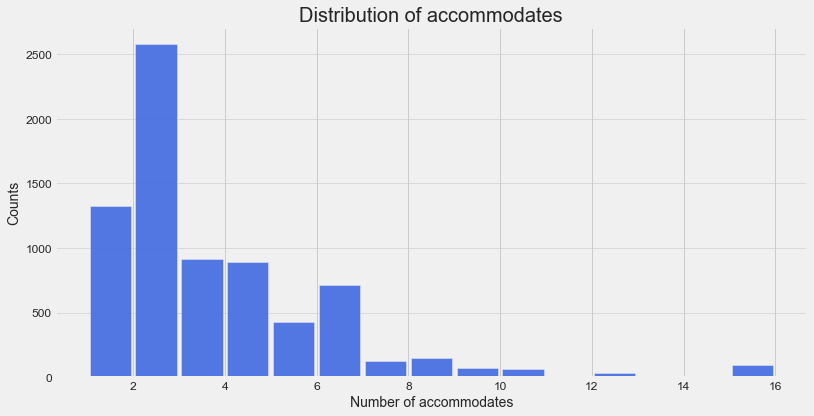

In [99]:
# distribution of the 'accommodates'

hist_plot('accommodates', 15, 'Number of accommodates', 'Distribution of accommodates')

# the number of accommodates falls mainly between 2-3

#### bathrooms    

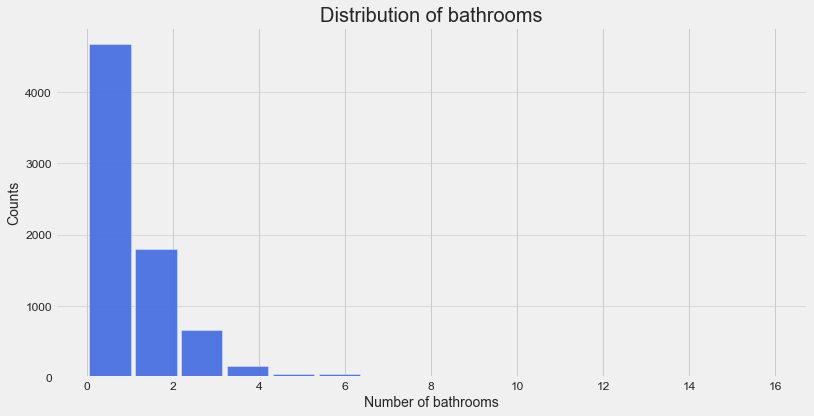

In [100]:
# distribution of the 'abathrooms'

hist_plot('bathrooms', 15 , 'Number of bathrooms', 'Distribution of bathrooms')

# the number of bathrooms falls mainly between 0-2

#### bedrooms  

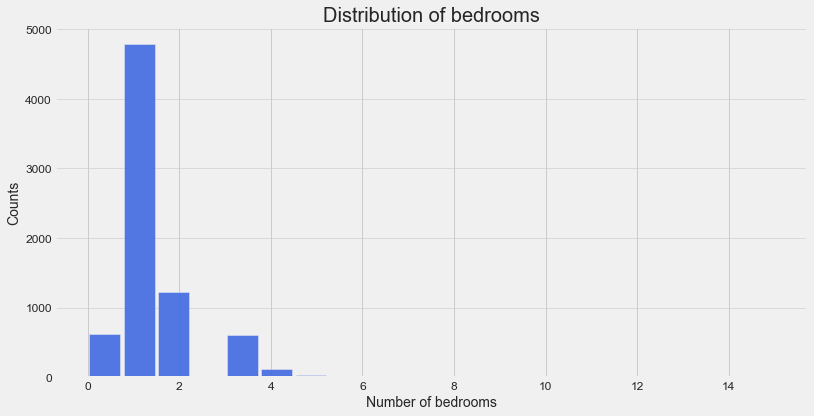

In [101]:
# distribution of the 'bedrooms'

hist_plot('bedrooms', 20, 'Number of bedrooms', 'Distribution of bedrooms')

# the number of bedrooms falls mainly between 1-2

#### beds  

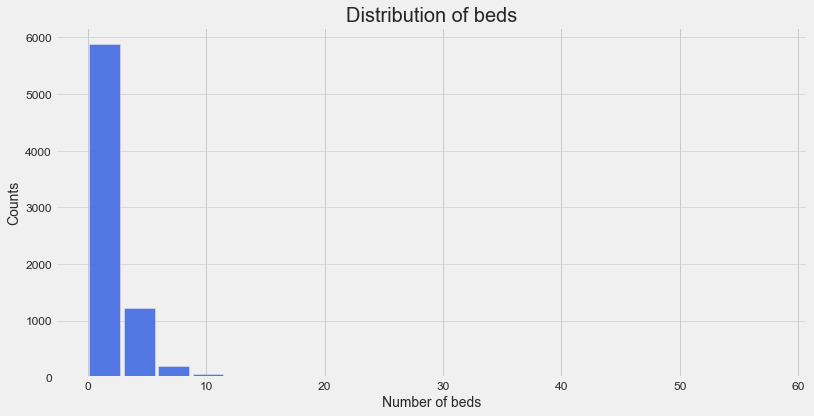

In [102]:
# distribution of the 'beds'

hist_plot('beds', 20, 'Number of beds', 'Distribution of beds')

# the number of beds falls mainly between 1-5.

#### security_deposit    

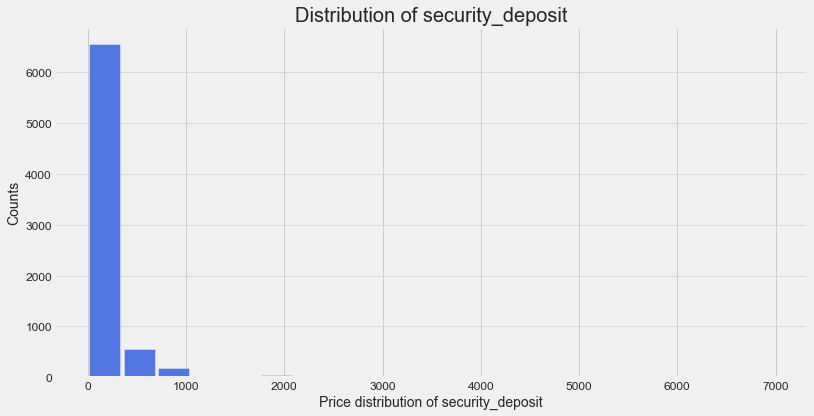

In [103]:
# distribution of the 'security_deposit'

hist_plot('security_deposit', 20, 'Price distribution of security_deposit', 'Distribution of security_deposit')

# the number of security_deposit falls mainly below $500

#### cleaning_fee 

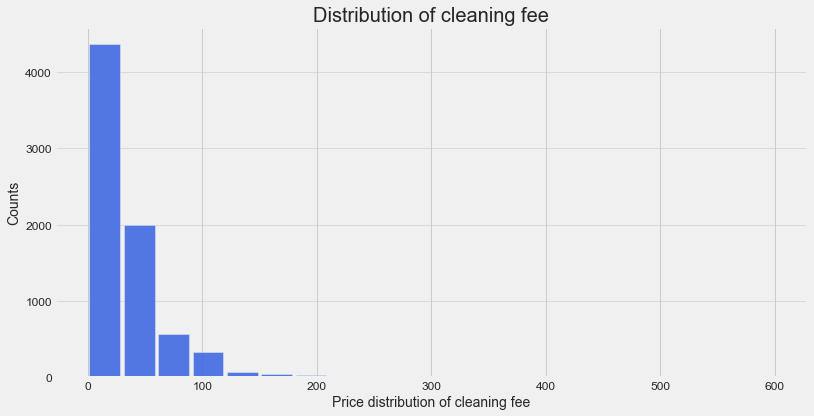

In [104]:
# distribution of the 'cleaning_fee'

hist_plot('cleaning_fee', 20, 'Price distribution of cleaning fee', 'Distribution of cleaning fee')

# the number of cleaning_fee falls mainly below $500

#### guests_included       

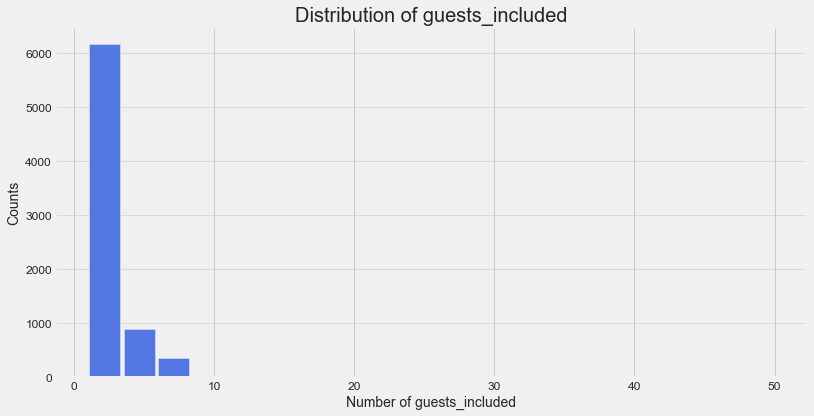

In [105]:
# distribution of the 'guests_included'

hist_plot('guests_included', 20, 'Number of guests_included', 'Distribution of guests_included')

# the number of guests_included is mainly 5 and below

#### extra_people   

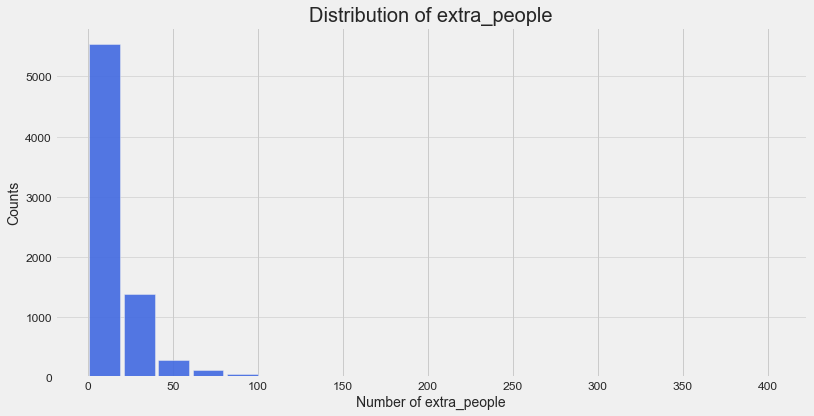

In [106]:
# distribution of the 'extra_people'

hist_plot('extra_people', 20, 'Number of extra_people', 'Distribution of extra_people')

# the number of extra_people is mainly 20 and below

#### availability_90 

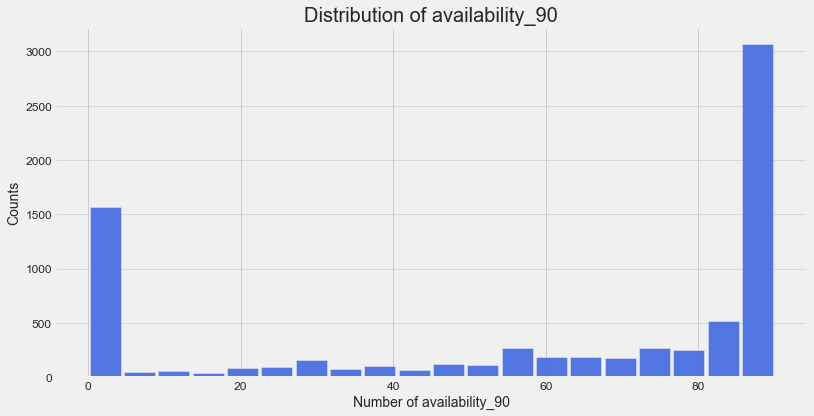

In [107]:
# distribution of the 'availability_90'

hist_plot('availability_90', 20, 'Number of availability_90', 'Distribution of availability_90')

# the number of availability_90 is mainly 20 and below

#### instant_bookable 

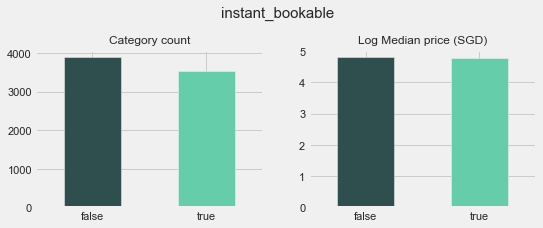

0   0.524502
1   0.475498
Name: instant_bookable, dtype: float64


In [108]:
# taking a look at the relationship between instant_bookable and median 
# price in that category

boolean_features('instant_bookable')
print(airbnb_data.instant_bookable.value_counts(normalize=True))

#### host_active  

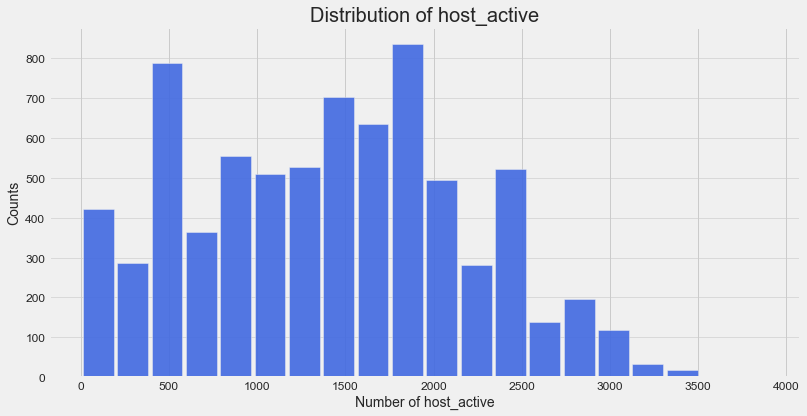

In [109]:
# distribution of the 'host_active'

hist_plot('host_active', 20, 'Number of host_active', 'Distribution of host_active')

# the number of host_active is mainly 20 and below

#### phone 

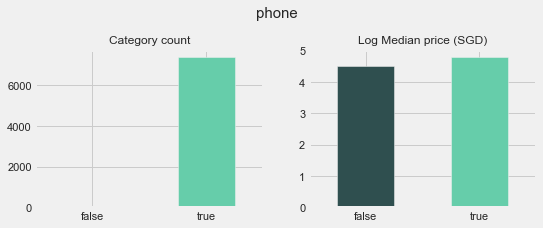

1   0.994884
0   0.005116
Name: phone, dtype: float64


In [110]:
# taking a look at the relationship between phone and median
# price in that category

boolean_features('phone')
print(airbnb_data.phone.value_counts(normalize=True))

#### email  

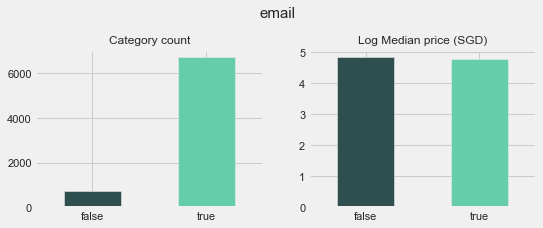

1   0.904685
0   0.095315
Name: email, dtype: float64


In [111]:
# taking a look at the relationship between email and median 
# price in that category

boolean_features('email')
print(airbnb_data.email.value_counts(normalize=True))

#### id_verification

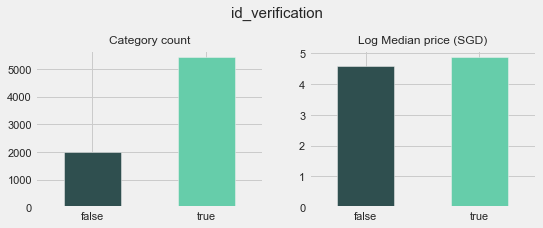

1   0.730749
0   0.269251
Name: id_verification, dtype: float64


In [112]:
# taking a look at the relationship between id_verfication and median
# price in that category

boolean_features('id_verification')
print(airbnb_data.id_verification.value_counts(normalize=True))

#### review 

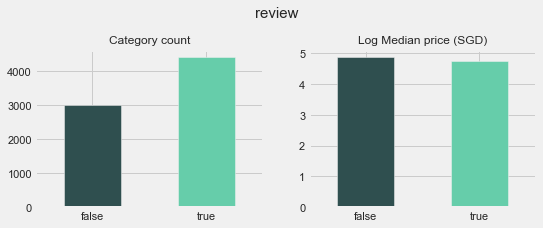

1   0.593834
0   0.406166
Name: review, dtype: float64


In [113]:
# taking a look at the relationship between review and median
# price in that category

boolean_features('review')
print(airbnb_data.review.value_counts(normalize=True))

#### photo     

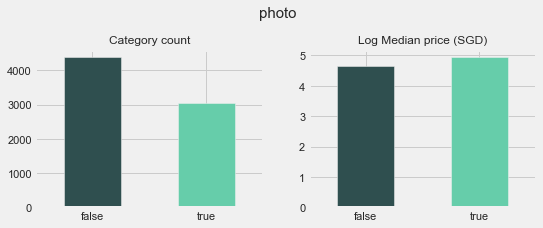

0   0.590603
1   0.409397
Name: photo, dtype: float64


In [114]:
# taking a look at the relationship between photo and median review
# price in that category

boolean_features('photo')
print(airbnb_data.photo.value_counts(normalize=True))

#### socials   

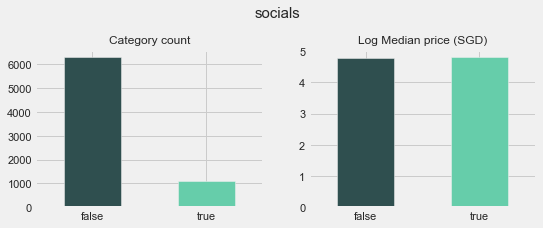

0   0.848950
1   0.151050
Name: socials, dtype: float64


In [115]:
# taking a look at the relationship between socials and median review
# price in that category

boolean_features('socials')
print(airbnb_data.socials.value_counts(normalize=True))

#### others   

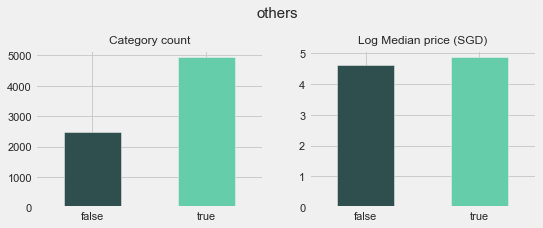

1   0.665724
0   0.334276
Name: others, dtype: float64


In [116]:
# taking a look at the relationship between others and median review
# price in that category

boolean_features('others')
print(airbnb_data.others.value_counts(normalize=True))

#### air_con    

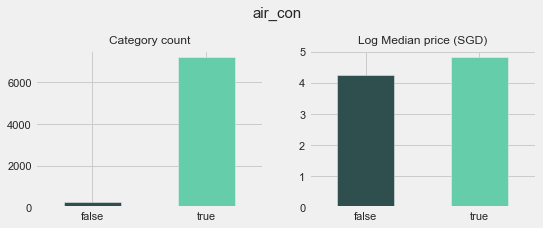

1   0.968094
0   0.031906
Name: air_con, dtype: float64


In [117]:
# taking a look at the relationship between air_con and median review
# price in that category

boolean_features('air_con')
print(airbnb_data.air_con.value_counts(normalize=True))

#### wifi   

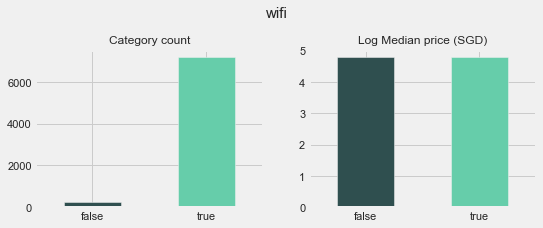

1   0.965940
0   0.034060
Name: wifi, dtype: float64


In [118]:
# taking a look at the relationship between wifi and median review
# price in that category

boolean_features('wifi')
print(airbnb_data.wifi.value_counts(normalize=True))

#### washer

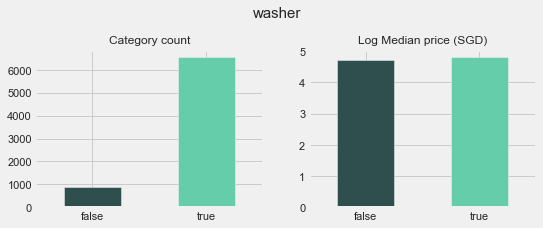

1   0.881799
0   0.118201
Name: washer, dtype: float64


In [119]:
# taking a look at the relationship between washer and median review
# price in that category

boolean_features('washer')
print(airbnb_data.washer.value_counts(normalize=True))

#### essentials 

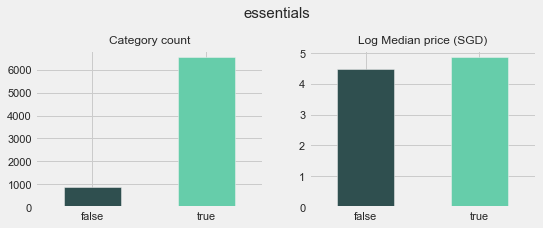

1   0.881395
0   0.118605
Name: essentials, dtype: float64


In [120]:
# taking a look at the relationship between essentials and median review
# price in that category

boolean_features('essentials')
print(airbnb_data.essentials.value_counts(normalize=True))

#### kitchen      

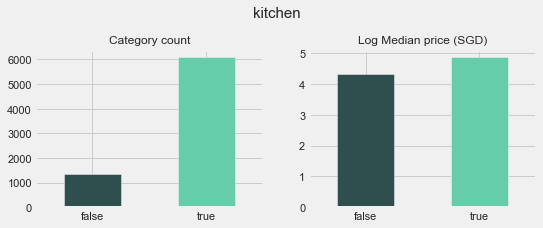

1   0.820409
0   0.179591
Name: kitchen, dtype: float64


In [121]:
# taking a look at the relationship between kitchen and median review
# price in that category

boolean_features('kitchen')
print(airbnb_data.kitchen.value_counts(normalize=True))

#### hangers    

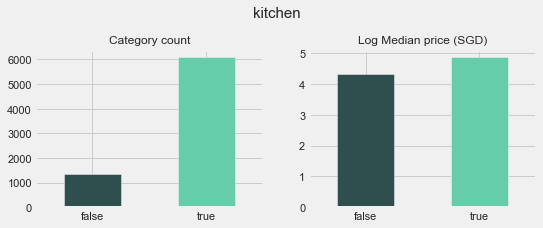

1   0.820409
0   0.179591
Name: kitchen, dtype: float64


In [122]:
# taking a look at the relationship between kitchen and median review
# price in that category

boolean_features('kitchen')
print(airbnb_data.kitchen.value_counts(normalize=True))

#### iron    

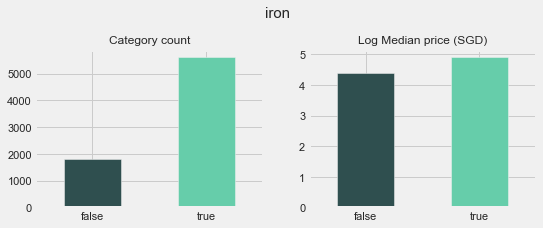

1   0.756193
0   0.243807
Name: iron, dtype: float64


In [123]:
# taking a look at the relationship between iron and median review
# price in that category

boolean_features('iron')
print(airbnb_data.iron.value_counts(normalize=True))

#### tv   

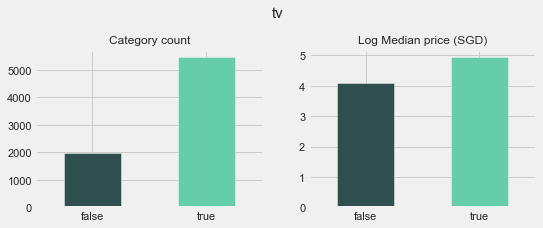

1   0.735057
0   0.264943
Name: tv, dtype: float64


In [124]:
# taking a look at the relationship between tv and median review
# price in that category

boolean_features('tv')
print(airbnb_data.tv.value_counts(normalize=True))

#### hair_dryer    

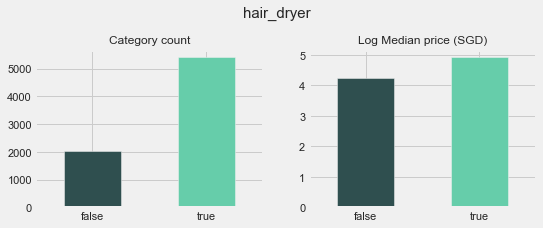

1   0.728325
0   0.271675
Name: hair_dryer, dtype: float64


In [125]:
# taking a look at the relationship between hair_dryer and median review
# price in that category

boolean_features('hair_dryer')
print(airbnb_data.hair_dryer.value_counts(normalize=True))

#### shampoo  

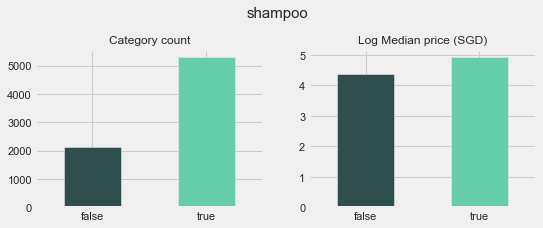

1   0.713920
0   0.286080
Name: shampoo, dtype: float64


In [126]:
# taking a look at the relationship between shampoo and median review
# price in that category

boolean_features('shampoo')
print(airbnb_data.shampoo.value_counts(normalize=True))

#### laptop_workspace      

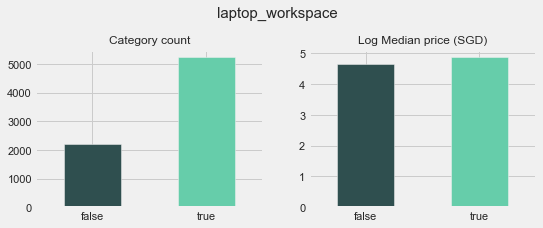

1   0.705035
0   0.294965
Name: laptop_workspace, dtype: float64


In [127]:
# taking a look at the relationship between laptop_workspace and median review
# price in that category

boolean_features('laptop_workspace')
print(airbnb_data.laptop_workspace.value_counts(normalize=True))

#### elevator 

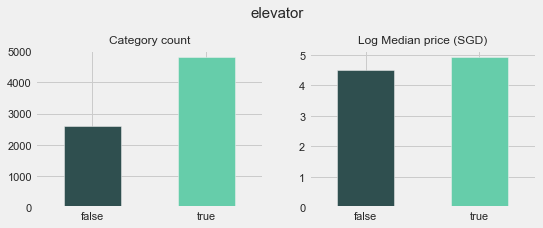

1   0.647415
0   0.352585
Name: elevator, dtype: float64


In [128]:
# taking a look at the relationship between elevator and median review
# price in that category

boolean_features('elevator')
print(airbnb_data.elevator.value_counts(normalize=True))

#### dryer 

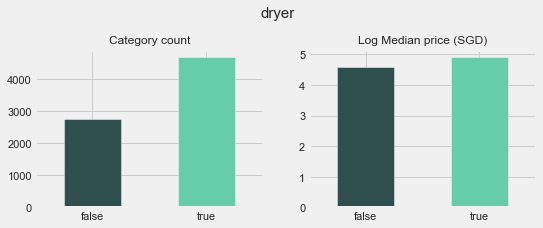

1   0.629645
0   0.370355
Name: dryer, dtype: float64


In [129]:
# taking a look at the relationship between dryer and median review
# price in that category

boolean_features('dryer')
print(airbnb_data.dryer.value_counts(normalize=True))

#### hot_water

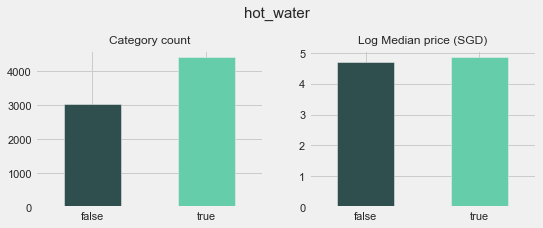

1   0.592488
0   0.407512
Name: hot_water, dtype: float64


In [130]:
# taking a look at the relationship between hot_water and median review
# price in that category

boolean_features('hot_water')
print(airbnb_data.hot_water.value_counts(normalize=True))

#### bedroom_lock    

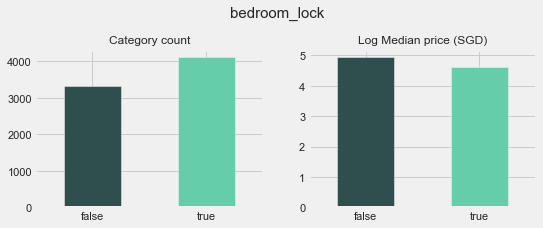

1   0.553985
0   0.446015
Name: bedroom_lock, dtype: float64


In [131]:
# taking a look at the relationship between bedroom_lock and median review
# price in that category

boolean_features('bedroom_lock')
print(airbnb_data.bedroom_lock.value_counts(normalize=True))

#### pool

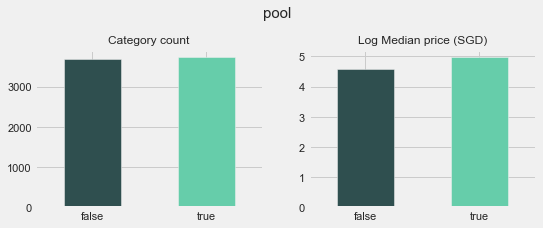

1   0.502693
0   0.497307
Name: pool, dtype: float64


In [132]:
# taking a look at the relationship between pool and median review
# price in that category

boolean_features('pool')
print(airbnb_data.pool.value_counts(normalize=True))

#### refrigerator   

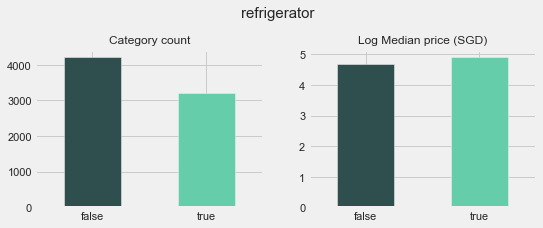

0   0.567582
1   0.432418
Name: refrigerator, dtype: float64


In [133]:
# taking a look at the relationship between refrigerator and median review
# price in that category

boolean_features('refrigerator')
print(airbnb_data.refrigerator.value_counts(normalize=True))

#### long_term_stays      

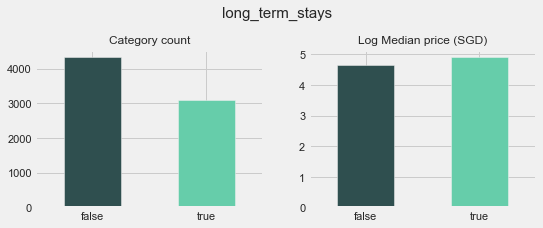

0   0.582660
1   0.417340
Name: long_term_stays, dtype: float64


In [134]:
# taking a look at the relationship between long_term_stays and median review
# price in that category

boolean_features('long_term_stays')
print(airbnb_data.long_term_stays.value_counts(normalize=True))

#### gym     

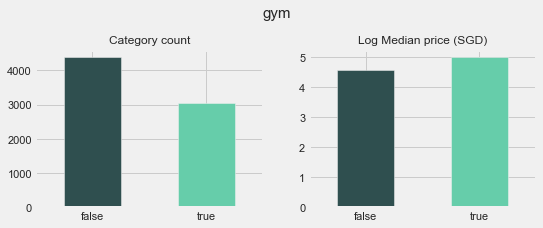

0   0.590199
1   0.409801
Name: gym, dtype: float64


In [135]:
# taking a look at the relationship between gym and median review
# price in that category

boolean_features('gym')
print(airbnb_data.gym.value_counts(normalize=True))

#### microwave    

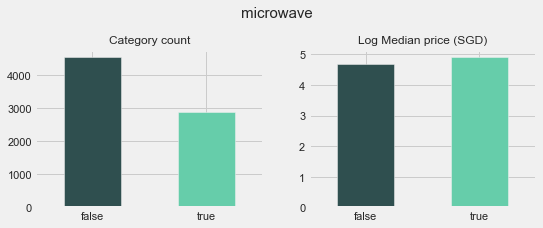

0   0.610932
1   0.389068
Name: microwave, dtype: float64


In [136]:
# taking a look at the relationship between microwave and median review
# price in that category

boolean_features('microwave')
print(airbnb_data.microwave.value_counts(normalize=True)) 

### Preparing data for Modelling

In [137]:
airbnb_data = airbnb_data.drop(columns = ['amenities',
                                          'host_since', 
                                          'host_verifications'])

In [138]:
airbnb_data.to_csv('../data/listings_cleaned.csv', index = False)